# make_tides:
## Make tides
### Version id:
### v1
### first go at converting
### https://github.com/dgwyther/ROMSForcingCreator/blob/master/tides/make_tides.m

In [1]:

run ='shac'
vers='2km_v3'
plotting = False

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import xarray as xr
import scipy.io as sio
from scipy.interpolate import griddata
import datetime
import cmocean
# import h5py
# import bathy_smoother
# import pyresample

import socket
comp_name = socket.gethostname()
if comp_name=='SEES-3PV4VV3':
    print('running locally')
else:
    os.chdir('/g/data/jk72/deg581/shackleton-setup/notebooks')


#proj_dir = os.path.join(os.pardir,os.pardir)
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.inverse_polar_stereo import inverse_polar_stereo
from ext.tools.cartesian_grid_2d import haversine
from ext.tools.NDinterp import NDinterp
from ext.tools.smoothing_PlusMinus_rx0 import smoothing_PlusMinus_rx0
from ext.tools.uvp_masks import uvp_masks





# define coordinate transforms
## convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

# load my functions for calculating rx0,rx1 and adjusting the grid
# from ext.tools.calc_z import calc_z as calc_z_old
from functions import GridStiffness
from functions.GridAdjustments import adjustWCT,adjustMask,smoothRegion,minWCTRegion

# Set model vertical coordinate settings

# N=31
# Vtransform=2
# Vstretching=4
# theta_s=4
# theta_b=1
# Tcline=300
# hc=Tcline # if Vtransform==2, hc=Tcline



# set user parameter and call main routine
#grd_file = os.path.join(data_dir,'proc',run+'_grd.nc')
grd_file = os.path.join(data_dir,'proc','shac_2km_v1_grd.nc')
out_file = os.path.join(data_dir,'proc',run+'_'+vers+'_tides.nc')


running locally



In [2]:
# load grid file
grd = xr.open_dataset(grd_file)

In [3]:
# import necessary TMD modules

import pyTMD.io
import pyTMD.time
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities

import pyproj

In [4]:
# corrrect some wierdness in teh cats2008_v2023 file from Chad
import os
if os.path.isfile('../../amery-hires-setup/data/raw/CATS2008_v2023/CATS2008_v2023_orig.nc'):
    print('not overwriting, already existing')
else:
    !cp -p ../../amery-hires-setup/data/raw/CATS2008_v2023/CATS2008_v2023.nc ../../amery-hires-setup/data/raw/CATS2008_v2023/CATS2008_v2023_orig.nc
cats2008_v2023 = xr.open_dataset('../../amery-hires-setup/data/raw/CATS2008_v2023/CATS2008_v2023_orig.nc')

cats2008_v2023['uRe'] = cats2008_v2023.URe
cats2008_v2023['uIm'] = cats2008_v2023.UIm

cats2008_v2023['vRe'] = cats2008_v2023.VRe
cats2008_v2023['vIm'] = cats2008_v2023.VIm


cats2008_v2023.to_netcdf('../../amery-hires-setup/data/raw/CATS2008_v2023/CATS2008_v2023.nc')

not overwriting, already existing


/tmp/ipykernel_32451/995909472.py:16: SerializationWarning: saving variable hRe with floating point data as an integer dtype without any _FillValue to use for NaNs
  cats2008_v2023.to_netcdf('../../amery-hires-setup/data/raw/CATS2008_v2023/CATS2008_v2023.nc')
/tmp/ipykernel_32451/995909472.py:16: SerializationWarning: saving variable hIm with floating point data as an integer dtype without any _FillValue to use for NaNs
  cats2008_v2023.to_netcdf('../../amery-hires-setup/data/raw/CATS2008_v2023/CATS2008_v2023.nc')


In [5]:
# available model list
model_list = sorted(pyTMD.io.model.global_current() + pyTMD.io.model.antarctic_current())
model_list

['CATS0201',
 'CATS2008',
 'CATS2008-v2023',
 'FES2014',
 'HAMTIDE11',
 'TPXO7.2',
 'TPXO8-atlas',
 'TPXO9-atlas',
 'TPXO9-atlas-v2',
 'TPXO9-atlas-v3',
 'TPXO9-atlas-v4',
 'TPXO9-atlas-v5',
 'TPXO9.1']

In [6]:

# display widgets for setting directory and model
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.options = model_list
TMDwidgets.model.value = 'CATS2008-v2023'
TMDwidgets.atlas.value = 'netcdf'
TMDwidgets.compress.value = False
TMDwidgets.datepick.value = datetime.date(2018, 1, 1)
TMDwidgets.directory.value = '../../amery-hires-setup/data/raw/'
# TMDwidgets.VBox([
#     TMDwidgets.directory,
#     TMDwidgets.model,
#     TMDwidgets.atlas,
#     TMDwidgets.compress,
#     TMDwidgets.datepick
# ])

In [7]:
# get model parameters
model = pyTMD.io.model(TMDwidgets.directory.value,
    format=TMDwidgets.atlas.value,
    compressed=TMDwidgets.compress.value
   ).elevation(TMDwidgets.model.value)

In [8]:
lon,lat = grd.lon_rho.values.flatten(),grd.lat_rho.values.flatten()

In [9]:
model.model_file

PosixPath('../../amery-hires-setup/data/raw/CATS2008_v2023/CATS2008_v2023.nc')

In [10]:
# convert from calendar date to days relative to Jan 1, 1992 (48622 MJD)
YMD = TMDwidgets.datepick.value
tide_time = pyTMD.time.convert_calendar_dates(YMD.year, YMD.month,
    YMD.day, hour=np.arange(24))
# delta time (TT - UT1) file
delta_file = pyTMD.utilities.get_data_path(['data','merged_deltat.data'])

# save tide currents
tide = {}
# iterate over u and v currents
for TYPE in model.type:
    # read tidal constants and interpolate to grid points
    if model.format in ('OTIS','ATLAS','TMD3'):
        amp,ph,D,constituents = pyTMD.io.OTIS.extract_constants(lon, lat, model.grid_file,
            model.model_file, model.projection, type=TYPE,
            method='spline', grid=model.format)
        DELTAT = np.zeros_like(tide_time)

['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']


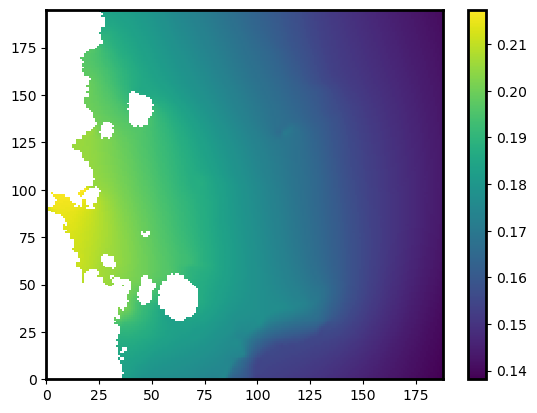

In [11]:
# reshape extracted constituents to actual size
amp_3d =np.reshape(amp,(*grd.lat_rho.shape,10))
ph_3d =np.reshape(ph,(*grd.lat_rho.shape,10))
print(constituents)
plt.pcolormesh(amp_3d[:,:,1])
plt.colorbar()

In [12]:
def _constituent_parameters(c: str, **kwargs):
    """
    Loads parameters for a given tidal constituent

    Parameters
    ----------
    c: str
        tidal constituent ID
    raise_error: bool, default False
        Raise exception if constituent is unsupported

    Returns
    -------
    amplitude: float
        amplitude of equilibrium tide for tidal constituent (meters)
    phase: float
        phase of tidal constituent (radians)
    omega: float
        angular frequency of constituent (radians)
    alpha: float
        load love number of tidal constituent
    species: float
        spherical harmonic dependence of quadrupole potential

    References
    ----------
    .. [1] G. D. Egbert and S. Y. Erofeeva, "Efficient Inverse Modeling of
        Barotropic Ocean Tides," *Journal of Atmospheric and Oceanic
        Technology*, 19(2), 183--204, (2002).
        `doi: 10.1175/1520-0426(2002)019<0183:EIMOBO>2.0.CO;2`__

    .. __: https://doi.org/10.1175/1520-0426(2002)019<0183:EIMOBO>2.0.CO;2
    """
    # default keyword arguments
    kwargs.setdefault('raise_error', False)
    # constituents array that are included in tidal program
    cindex = ['m2', 's2', 'k1', 'o1', 'n2', 'p1', 'k2', 'q1', '2n2', 'mu2',
        'nu2', 'l2', 't2', 'j1', 'm1', 'oo1', 'rho1', 'mf', 'mm', 'ssa',
        'm4', 'ms4', 'mn4', 'm6', 'm8', 'mk3', 's6', '2sm2', '2mk3',
        'msf', 'sa', 'mt', '2q1']
    # species type (spherical harmonic dependence of quadrupole potential)
    _species = np.array([2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
    # Load Love numbers
    # alpha = correction factor for first order load tides
    _alpha = np.array([0.693, 0.693, 0.736, 0.695, 0.693, 0.706, 0.693,
        0.695, 0.693, 0.693, 0.693, 0.693, 0.693, 0.695, 0.695, 0.695, 0.695,
        0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693,
        0.693, 0.693, 0.693, 0.693, 0.693, 0.693])
    # omega: angular frequency of constituent, in radians
    _omega = np.array([1.405189e-04, 1.454441e-04, 7.292117e-05, 6.759774e-05,
        1.378797e-04, 7.252295e-05, 1.458423e-04, 6.495854e-05, 1.352405e-04,
        1.355937e-04, 1.382329e-04, 1.431581e-04, 1.452450e-04, 7.556036e-05,
        7.028195e-05, 7.824458e-05, 6.531174e-05, 0.053234e-04, 0.026392e-04,
        0.003982e-04, 2.810377e-04, 2.859630e-04, 2.783984e-04, 4.215566e-04,
        5.620755e-04, 2.134402e-04, 4.363323e-04, 1.503693e-04, 2.081166e-04,
        4.925200e-06, 1.990970e-07, 7.962619e-06, 6.231934e-05])
    # Astronomical arguments (relative to t0 = 1 Jan 0:00 1992)
    # phases for each constituent are referred to the time when the phase of
    # the forcing for that constituent is zero on the Greenwich meridian
    _phase = np.array([1.731557546, 0.000000000, 0.173003674, 1.558553872,
        6.050721243, 6.110181633, 3.487600001, 5.877717569, 4.086699633,
        3.463115091, 5.427136701, 0.553986502, 0.052841931, 2.137025284,
        2.436575100, 1.929046130, 5.254133027, 1.756042456, 1.964021610,
        3.487600001, 3.463115091, 1.731557546, 1.499093481, 5.194672637,
        6.926230184, 1.904561220, 0.000000000, 4.551627762, 3.809122439,
        4.551627762, 6.232786837, 3.720064066, 3.91369596])
    # amplitudes of equilibrium tide in meters
    # _amplitude = np.array([0.242334,0.112743,0.141565,0.100661,0.046397,
    _amplitude = np.array([0.2441, 0.112743, 0.141565, 0.100661, 0.046397,
        0.046848, 0.030684, 0.019273, 0.006141, 0.007408, 0.008811, 0.006931,
        0.006608, 0.007915, 0.007915, 0.004338, 0.003661, 0.042041, 0.022191,
        0.019567, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.003681, 0.003104,
        0.008044, 0.002565])

    # map between input constituent and cindex
    j = [j for j,val in enumerate(cindex) if (val == c.lower())]
    # set the values for the constituent
    if j:
        amplitude, = _amplitude[j]
        phase, = _phase[j]
        omega, = _omega[j]
        alpha, = _alpha[j]
        species, = _species[j]
    elif kwargs['raise_error']:
        raise ValueError(f'Unsupported constituent {c}')
    else:
        amplitude = 0.0
        phase = 0.0
        omega = 0.0
        alpha = 0.0
        species = 0
    # return the values for the constituent
    return (amplitude, phase, omega, alpha, species)

In [13]:
# make vector with all hourly periods
period = np.ones((len(constituents),1))*np.NaN
for i,cons in enumerate(constituents):
    print(cons)
    _,_,angfreq,_,_ = _constituent_parameters(cons)
    T = 2*np.pi/angfreq / (60*60)
    print(T)
    period[i] = T
    
period = period.squeeze()

m2
12.420601442185568
s2
12.000000357486687
n2
12.658348197699366
k2
11.967236199609644
k1
23.934465834740852
o1
25.81934325014904
p1
24.0658888254591
q1
26.868357139712955
mf
327.85987376382195
mm
661.3099621075816


In [14]:
# tmask.isel(xi_rho=-1).plot()
# grd.mask_rho.shape[0]

In [15]:
# Do we want to only force the boundaries?
only_force_bnds = 1
if only_force_bnds: # only force boundaries
    tmask = np.zeros(grd.lat_rho.shape)
    tmask[:,0] = 1
    tmask[:,-1] = 1
    tmask[0, ]= 1
    tmask[-1,] = 1
    
        
    # add extra buffer
    # tmask[0,:]=0
    # tmask[-1,:]=0
    # tmask[:,-1]=0
    tmask = tmask*0.5
    
    # under_ice_mask = grd.mask_rho[grd.zice < 0] = 0; # don't force under ice shelves
    mask_nozice = grd.mask_rho.where(grd.zice>=0,0) * grd.mask_rho
    
    tmask = tmask*grd.mask_rho*mask_nozice

    
    tmask_big=np.ones((grd.mask_rho.shape[0],grd.mask_rho.shape[1],10))*np.NaN    
    for nn in range(len(constituents)):
        tmask_big[:,:,nn] = tmask
# elif 0: # force whole surface
#     # mask_zice = ncread(grdname,'mask_zice')';
#     # tmask = ones(pp,qq);
#     # %ma = mask_rho;
#     # mask_rho(mask_zice == 1) = 0;

# plt.figure(figsize=(10,10))
# plt.pcolormesh(tmask*grd.mask_rho*mask_nozice)
# plt.axis((-10,910,-10,800))
# plt.colorbar()
# plt.show()

# plt.figure(figsize=(10,10))
# plt.pcolormesh(mask_nozice)
# plt.axis((-10,910,-10,800))
# plt.colorbar()

# plt.figure(figsize=(10,10))
# plt.pcolormesh(mask_nozice*grd.zice)
# plt.axis((-10,910,-10,800))
# plt.colorbar()
    # mask out ice shelves and non-ocean, and fill nan with 0.
    amp_3d_unm = amp_3d.copy()
    ph_3d_unm = ph_3d.copy()
    amp_3d = amp_3d.filled(fill_value=0)*tmask_big
    ph_3d = ph_3d.filled(fill_value=0)*tmask_big



In [16]:
# check for nans and other bad values
variables = ['tide_Eamp','tide_Ephase','tide_period']



for arr_name in variables:
    arr = locals().get(arr_name)
    if arr is not None:
        if np.isnan(arr).any():
            print(f"Warning: NaN found in array '{arr_name}'")
    else:
        print('no NaN in '+arr_name)
            


no NaN in tide_Eamp
no NaN in tide_Ephase
no NaN in tide_period


In [17]:

tide_Eamp_da = xr.DataArray(amp_3d,name='tide_Eamp',dims=['eta_rho','xi_rho','tide_period'],attrs={'long_name': 'tidal elevation amplitude',
 'units': 'metres',
 'field': 'tide_Eamp, scalar'})
tide_Ephase_da = xr.DataArray(ph_3d,name='tide_Ephase',dims=['eta_rho','xi_rho','tide_period'],attrs={'long_name': 'tidal elevation phase angle',
'units': 'degrees, time of maximum elevation with respect to chosen time origin',
 'field': 'tide_Ephase, scalar'})
tide_Eamp_unmasked_da = xr.DataArray(amp_3d_unm,name='tide_Eamp_unmasked',dims=['eta_rho','xi_rho','tide_period'],attrs={'long_name': 'tidal elevation amplitude, unmasked',
 'units': 'metres',
 'field': 'tide_Eamp, scalar'})
tide_Ephase_unmasked_da = xr.DataArray(ph_3d_unm,name='tide_Ephase_unmasked',dims=['eta_rho','xi_rho','tide_period'],attrs={'long_name': 'tidal elevation phase angle, unmasked',
'units': 'degrees, time of maximum elevation with respect to chosen time origin',
 'field': 'tide_Ephase, scalar'})
tide_period_da = xr.DataArray(period,name='tide_period',dims=['tide_period'],attrs={ 'long_name': 'tide angular period',
'units':'hours',
'field':'tide_period, scalar'})



tds = xr.Dataset({'tide_Eamp':tide_Eamp_da,
                'tide_Ephase':tide_Ephase_da,
                'tide_Eamp_unmasked':tide_Eamp_unmasked_da,
                'tide_Ephase_unmasked':tide_Ephase_unmasked_da,
                'tide_period':tide_period_da},
               attrs={'title':run+'_'+vers+'_tides.nc',
                      'history': 'TIDE file using make_tide.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file',
                      'grd_file':grd_file,
                      'components':constituents})

tds = tds.assign_coords({'tide_period':tide_period_da})

# reorganise dimensions
tds = tds.transpose('tide_period','eta_rho','xi_rho')

In [18]:
print('saving to',out_file)
tds.to_netcdf(out_file)

saving to /home/woden/Documents/shackleton-setup/data/proc/shac_2km_v3_tides.nc


In [ ]:
STOP

In [19]:
# tds.tide_Eamp.isel(eta_rho=0,n_constituent=0).plot()
# plt.show()
# tmask.plot()
# plt.ylim((-5,15))
# plt.show()
# plt.pcolormesh(mask_nozice)
# plt.ylim((-5,15))
# plt.show()
# plt.pcolormesh(grd.zice<0)
# plt.ylim((-5,15))


In [20]:

# plt.figure(figsize=(20,20))
# tds.tide_Eamp.isel(n_constituent=3).plot()
# plt.axis((-10,910,-10,760))
# plt.show()
# plt.figure(figsize=(20,20))
# tds.tide_Eamp_unmasked.isel(n_constituent=3).plot()
# plt.axis((-10,910,-10,760))

(-5.0, 200.0, -5.0, 200.0)

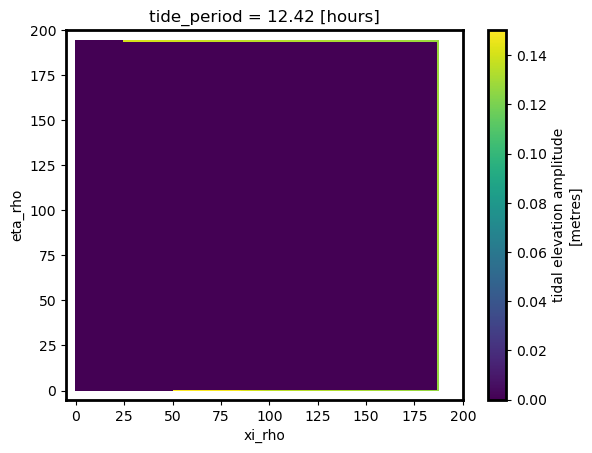

In [21]:
tds.tide_Eamp.isel(tide_period=0).plot()
plt.axis((-5,200,-5,200))

In [22]:
tisom = xr.open_dataset('../../../Downloads/tisom001_tides.nc')

plt.figure(figsize=(20,20))
tisom.tide_Eamp.isel(tide_period=0).plot()

FileNotFoundError: [Errno 2] No such file or directory: '/home/woden/Downloads/tisom001_tides.nc'

In [ ]:
tds

In [ ]:
tisom.tide_Eamp.isel(tide_period=0).plot()

In [ ]:
STOP

In [ ]:
## Working below

In [ ]:
# get model parameters
model = pyTMD.io.model(TMDwidgets.directory.value,
    format=TMDwidgets.atlas.value,
    compressed=TMDwidgets.compress.value
   ).current(TMDwidgets.model.value)

In [ ]:
# create an image around Antarctica
xlimits = [-560.*5e3,560.*5e3]
ylimits = [-560.*5e3,560.*5e3]
spacing = [20e3,-20e3]
# x and y coordinates
x = np.arange(xlimits[0],xlimits[1]+spacing[0],spacing[0])
y = np.arange(ylimits[1],ylimits[0]+spacing[1],spacing[1])
xgrid,ygrid = np.meshgrid(x,y)
# x and y dimensions
nx = int((xlimits[1]-xlimits[0])/spacing[0])+1
ny = int((ylimits[0]-ylimits[1])/spacing[1])+1
# convert image coordinates from polar stereographic to latitude/longitude
crs1 = pyproj.CRS.from_epsg(3031)
crs2 = pyproj.CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(crs1, crs2, always_xy=True)
lon,lat = transformer.transform(xgrid.flatten(), ygrid.flatten())

In [ ]:
# convert from calendar date to days relative to Jan 1, 1992 (48622 MJD)
YMD = TMDwidgets.datepick.value
tide_time = pyTMD.time.convert_calendar_dates(YMD.year, YMD.month,
    YMD.day, hour=np.arange(24))
# delta time (TT - UT1) file
delta_file = pyTMD.utilities.get_data_path(['data','merged_deltat.data'])

# save tide currents
tide = {}
# iterate over u and v currents
for TYPE in model.type:
    # read tidal constants and interpolate to grid points
    if model.format in ('OTIS','ATLAS','TMD3'):
        amp,ph,D,c = pyTMD.io.OTIS.extract_constants(lon, lat, model.grid_file,
            model.model_file['u'], model.projection, type=TYPE,
            method='spline', grid=model.format)
        DELTAT = np.zeros_like(tide_time)
    elif (model.format == 'netcdf'):
        amp,ph,D,c = pyTMD.io.ATLAS.extract_constants(lon, lat, model.grid_file,
            model.model_file[TYPE], type=TYPE, method='spline',
            scale=model.scale, compressed=model.compressed)
        DELTAT = np.zeros_like(tide_time)
    elif (model.format == 'GOT'):
        amp,ph,c = pyTMD.io.GOT.extract_constants(lon, lat, model.model_file[TYPE],
            method='spline', scale=model.scale,
            compressed=model.compressed)
        # interpolate delta times from calendar dates to tide time
        DELTAT = pyTMD.time.interpolate_delta_time(delta_file, tide_time)
    elif (model.format == 'FES'):
        amp,ph = pyTMD.io.FES.extract_constants(lon, lat, model.model_file[TYPE],
            type=TYPE, version=model.version, method='spline',
            scale=model.scale, compressed=model.compressed)
        c = model.constituents
        # interpolate delta times from calendar dates to tide time
        DELTAT = pyTMD.time.interpolate_delta_time(delta_file, tide_time)
        
    # calculate complex phase in radians for Euler's
    cph = -1j*ph*np.pi/180.0
    # calculate constituent oscillation
    hc = amp*np.exp(cph)

    # allocate for tide current map calculated every hour
    tide[TYPE] = np.ma.zeros((ny,nx,24))
    for hour in range(24):
        # predict tidal elevations at time and infer minor corrections
        TIDE = pyTMD.predict.map(tide_time[hour], hc, c, deltat=DELTAT[hour],
            corrections=model.format)
        MINOR = pyTMD.predict.infer_minor(tide_time[hour], hc, c,
            deltat=DELTAT[hour], corrections=model.format)
        # add major and minor components and reform grid
        tide[TYPE][:,:,hour] = np.reshape((TIDE+MINOR),(ny,nx))

In [ ]:
import matplotlib.animation as animation
import cartopy.crs as ccrs
from IPython.display import HTML

# output Antarctic Tidal Current Animation
projection = ccrs.Stereographic(central_longitude=0.0,
    central_latitude=-90.0,true_scale_latitude=-71.0)
# figure axis and image objects
ax1,im = ({},{})
fig, (ax1['u'],ax1['v']) = plt.subplots(num=1, ncols=2,
    figsize=(11.5,7), subplot_kw=dict(projection=projection))
vmin = -100 #np.min([tide['u'].min(),tide['v'].min()])
vmax = 100 #np.max([tide['u'].max(),tide['v'].max()])
extent = (xlimits[0],xlimits[1],ylimits[0],ylimits[1])
for TYPE,ax in ax1.items():
    # plot tidal currents
    im[TYPE] = ax.imshow(np.zeros((ny,nx)),
        interpolation='nearest', vmin=vmin, vmax=vmax,
        transform=projection, extent=extent, origin='upper',
        animated=True)
    # add high resolution cartopy coastlines
    ax.coastlines('10m')
    # set x and y limits
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)
    # stronger linewidth on frame
    ax.spines['geo'].set_linewidth(2.0)
    ax.spines['geo'].set_capstyle('projecting')

# Add colorbar with a colorbar axis
# Add an axes at position rect [left, bottom, width, height]
cbar_ax = fig.add_axes([0.085, 0.075, 0.83, 0.035])
# extend = add extension triangles to upper and lower bounds
# options: neither, both, min, max
cbar = fig.colorbar(im['u'], cax=cbar_ax, extend='both',
    extendfrac=0.0375, drawedges=False, orientation='horizontal')
# rasterized colorbar to remove lines
cbar.solids.set_rasterized(True)
# Add label to the colorbar
cbar.ax.set_title(f'{model.name} Tidal Velocity', fontsize=13,
    rotation=0, y=-1.65, va='top')
cbar.ax.set_xlabel('cm/s', fontsize=13, rotation=0, va='center')
cbar.ax.xaxis.set_label_coords(1.075, 0.5)
# ticks lines all the way across
cbar.ax.tick_params(which='both', width=1, length=18,
    labelsize=13, direction='in')

# add title (date and time)
ttl = fig.suptitle(None, y=0.97, fontsize=13)
# adjust subplot within figure
fig.subplots_adjust(left=0.02,right=0.98,bottom=0.1,top=0.98,wspace=0.04)
           
# animate each map
def animate_maps(hour):
    # set map data iterating over u and v currents
    for TYPE in model.type:
        im[TYPE].set_data(tide[TYPE][:,:,hour])
    # set title
    args = (YMD.year,YMD.month,YMD.day,hour)
    ttl.set_text('{0:4d}-{1:02d}-{2:02d}T{3:02d}:00:00'.format(*args))

# set animation
anim = animation.FuncAnimation(fig, animate_maps, frames=24)
%matplotlib inline
HTML(anim.to_jshtml())

In [ ]:
STOP

In [ ]:
mr = 2
grid_xLims= (1500,3300) #km
grid_yLims= (0,1500) #km
#establish the grid with grid point distances of mr/2 in km
#we need double resolution to cover all of the staggered grid points (we subset to rho, psi, u, v points later)
#we need an extra line of u and v points at first to calculate all dx and dy on rho points
x,y = np.meshgrid(np.arange(grid_xLims[0],grid_xLims[1]+mr/2,mr/2),np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2))
x_rho = x[1::2,1::2]
y_rho = y[1::2,1::2]

In [ ]:
#load GEBCO 2023 geometry

gebco_2023_bed = os.path.join(data_dir,'raw','GEBCO_2023','GEBCO_2023_sub_ice_topo.nc')

g23 = xr.load_dataset(gebco_2023_bed)

g23 = g23.sel(lon=slice(30,110),lat=slice(-85,-55))
g23

long,latg = np.meshgrid(g23.lon,g23.lat)
g23 = g23.assign_coords({"longitude": (("lat", "lon"), long), "latitude": (("lat", "lon"), latg)})

In [ ]:
#load BM3 geometry
bedmachine_v3_path = os.path.join(data_dir,'raw','BedMachineAntarctica-v3','BedMachineAntarctica-v3.nc')

bm3_raw = xr.load_dataset(bedmachine_v3_path)

#subset bedmachine dataset
bm3=bm3_raw.sel(x=slice(1e6,3.3e6)).sel(y=slice(1.5e6,0)) # note reversed y coord

# make XX and YY coordinates
X,Y = np.meshgrid(bm3.x,bm3.y)
bm3 = bm3.assign_coords({"X": (("y", "x"), X), "Y": (("y", "x"), Y)})

bm3_lat,bm3_lon = ps_to_ll.transform(bm3.X,bm3.Y)
bm3 = bm3.assign_coords({"lon": (("y", "x"), bm3_lon), "lat": (("y", "x"), bm3_lat)})

# make 'draft' abd 'bathy' variables
bm3["draft"]=-(bm3.thickness-bm3.surface) #draft is negative
bm3["bathy"]=-bm3.bed # bathy is postive


In [ ]:
whichBathy='bedmachine' #options: 'bedmachine' or 'gebco'
if whichBathy =='gebco':
    # make new dataset with all variables on same grid
    geom = bm3.draft.to_dataset(name='draft')

    # interp GEBCO2023 bathy to this grid.
    g23_bathy_i = -griddata((g23['longitude'].values.flatten(),g23['latitude'].values.flatten()),g23['elevation'].values.flatten(),(geom.lon.values,geom.lat.values),'nearest').astype(np.float32)
    geom['bathy']=(['y','x'],g23_bathy_i)


    # make masks
    geom['mask_full']=bm3.mask
    geom["mask_ice"]=np.isfinite(geom.mask_full.where(geom.mask_full==3,np.NaN))
    geom["mask_ocean"]=np.isfinite(geom.mask_full.where((geom.mask_full==0)|(geom.mask_full==3),np.NaN))
elif whichBathy =='bedmachine':
    
    geom = bm3
    # make masks
    geom['mask_full']=bm3.mask
    geom["mask_ice"]=np.isfinite(geom.mask_full.where(geom.mask_full==3,np.NaN))
    geom["mask_ocean"]=np.isfinite(geom.mask_full.where((geom.mask_full==0)|(geom.mask_full==3),np.NaN))
    


In [ ]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.set_extent([64, 80, -75, -62])

#add data
im = (geom['bathy']).plot.contourf(x='lon',y='lat',cmap='cmo.deep',levels=np.array([*np.arange(00,3250,250)]),add_colorbar=False)
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


In [ ]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.set_extent([64, 80, -75, -62])

#add data
im = (geom.draft).plot.contourf(x='lon',y='lat',cmap='cmo.ice',levels=np.array([*np.arange(-2250,50,50)]),add_colorbar=False,extend='min')
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


In [ ]:
# geom.draft.plot(x='lon',y='lat')

trans_lon = np.ones(1000)*68
trans_lat = np.linspace(-68.2,-65,1000)

from scipy.interpolate import griddata
lat_s = geom.lat.values.flatten()
lon_s = geom.lon.values.flatten()

trans_draft = griddata((lon_s,lat_s),geom['draft'].values.flatten(),(trans_lon,trans_lat),'nearest')
trans_bathy = griddata((lon_s,lat_s),geom['bathy'].values.flatten(),(trans_lon,trans_lat),'nearest')


In [ ]:
plt.plot(trans_lat,trans_draft)
plt.plot(trans_lat,-trans_bathy)


In [ ]:
# plot of chosen subset
fig,ax=plt.subplots(figsize=(20,13))
geom.bathy.plot(vmin=000,vmax=5000,cmap='cmo.deep_r')
geom.mask_ocean.plot.contour(colors='k')
ax.set_aspect('equal','box')

plt.show()
fig,ax=plt.subplots(figsize=(20,13))
geom.draft.plot(vmin=-2500,vmax=0,cmap='cmo.ice')
geom.mask_ice.plot.contour(colors='k')
ax.set_aspect('equal','box')

In [ ]:
#load south polar stereographic projection to convert from grid point distance in m to lat/lon and back

#get lat/lon coordinates at all grid points by shifting the grid to the lower left corner of the map
lat,lon = inverse_polar_stereo(x,y,0,0,-71.0)

#calculate curvilinear coordinate distances at rho points
dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])


#calculate curvilinear coordinate metrices
pm = 1.0/dx
pn = 1.0/dy
 
dndx = np.empty_like(pm)
dmde = np.empty_like(pn)

dndx[:,1:-1] = 0.5*(pn[:,2:] - pn[:,:-2])
dmde[1:-1,:] = 0.5*(pm[2:,:] - pm[:-2,:])

dndx[:,0]  = 2*dndx[:,1]  - dndx[:,2]
dndx[:,-1] = 2*dndx[:,-2] - dndx[:,-3]
dmde[0,:]  = 2*dmde[1,:]  - dmde[2,:]
dmde[-1,:] = 2*dmde[-2,:] - dmde[-3,:]

#subset lat and lon at rho, psi, u and v points
lon_rho = lon[1::2,1::2]
lat_rho = lat[1::2,1::2]

lon_psi = lon[2:-1:2,2:-1:2]
lat_psi = lat[2:-1:2,2:-1:2]

lon_u = lon[1::2,2:-1:2]
lat_u = lat[1::2,2:-1:2]

lon_v = lon[2:-1:2,1::2]
lat_v = lat[2:-1:2,1::2]

In [ ]:
# convert the final rho,psi,u,v points to x,y grid

x_rho,y_rho = ll_to_ps.transform(lat_rho,lon_rho)
x_psi,y_psi = ll_to_ps.transform(lat_psi,lon_psi)
x_u,y_u = ll_to_ps.transform(lat_u,lon_u)
x_v,y_v = ll_to_ps.transform(lat_v,lon_v)




In [ ]:
lat_s = geom.lat.values.flatten()
lon_s = geom.lon.values.flatten()

In [ ]:
# interpolate from the geometry grid to the new roms grid

from scipy.interpolate import griddata

def grid_data(data):
    return griddata((lon_s,lat_s),data,(lon_rho,lat_rho),'nearest')

roms_tmp = {}
for key in ['bathy','draft','mask_ice','mask_ocean']:
    roms_tmp[key] = grid_data(geom[key].values.flatten())
    print('interpolated',key)

In [ ]:
if plotting:
    plt.close()
    for key,data in roms_tmp.items():
        fig,ax = plt.subplots(figsize=(15,10))
        if key=='draft':
            plot = ax.pcolormesh(data)        
        else:
            plot = ax.pcolormesh(data)
        ax.set_title(key)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('equal')
        plt.show()

In [ ]:


z_rho_pre,z_w_pre,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bathy'],roms_tmp['draft'])


fig = plt.figure(figsize=(20,10))
grd_rx0_pre=GridStiffness.rx0(roms_tmp['bathy'],roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx0_pre)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_pre=GridStiffness.rx1(z_w_pre,roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx1_pre)
plt.colorbar()
plt.show()

In [ ]:
# make amery mask for calculating cavity volume
rough_mask = np.zeros(roms_tmp['draft'].shape)
rough_mask[300:440,0:368]=1

mask_amery = (roms_tmp['draft']<0) & (roms_tmp['mask_ocean']==1) & (rough_mask==1)

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(mask_amery)
plt.colorbar()

print('initial cavity volume')
print(np.sum(mask_amery*(roms_tmp['draft']+roms_tmp['bathy'])*dx*dy),'m3')
print(np.sum(mask_amery*(roms_tmp['draft']+roms_tmp['bathy'])*dx*dy)/1e12,'x10^12 m3')

initial_volume = np.sum(mask_amery*(roms_tmp['draft']+roms_tmp['bathy'])*dx*dy)


In [ ]:
# First need to check for any badly masked points - before any smoothing happens
Thresh = 25


fig = plt.figure(figsize=(20,10))
thin_WCT = (roms_tmp['bathy']+roms_tmp['draft'])*roms_tmp['mask_ocean']
plt.pcolormesh(thin_WCT,vmin=0,vmax=50)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
thin_WCT_mask = (thin_WCT<Thresh) & (roms_tmp['mask_ocean']==1)
plt.pcolormesh(thin_WCT_mask)
plt.colorbar()


In [ ]:
plt.figure()
plot_where=120
plt.plot(-roms_tmp['bathy'][:,plot_where],'.-')
plt.plot(roms_tmp['draft'][:,plot_where],'.-')
plt.plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
plt.axis((345,375,-2600,0))
print(roms_tmp['bathy'][352,plot_where])
print(roms_tmp['draft'][352,plot_where])
print(roms_tmp['mask_ocean'][352,plot_where])
print((roms_tmp['bathy'][352,plot_where]+roms_tmp['draft'][352,plot_where])*roms_tmp['mask_ocean'][352,plot_where])

plt.figure()
plot_where=270
plt.plot(-roms_tmp['bathy'][:,plot_where],'.-')
plt.plot(roms_tmp['draft'][:,plot_where],'.-')
plt.plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
plt.axis((345,420,-1500,0))

print(roms_tmp['bathy'][410,plot_where])
print(roms_tmp['draft'][410,plot_where])
print(roms_tmp['mask_ocean'][410,plot_where])
print((roms_tmp['bathy'][410,plot_where]+roms_tmp['draft'][410,plot_where])*roms_tmp['mask_ocean'][410,plot_where])

plt.show()
plt.figure()
plt.pcolormesh((roms_tmp['bathy']-roms_tmp['draft'])*roms_tmp['mask_ocean'])
plt.axvline(plot_where,color='C1')
plot_where=270
plt.axvline(plot_where,color='C2')

plt.axis((200,400,300,500))
plt.colorbar()

plt.show()
plt.figure()
plot_where=270
plt.pcolormesh((roms_tmp['bathy']+roms_tmp['draft'])*roms_tmp['mask_ocean'],vmin=0,vmax=100)
plt.axis((200,400,300,500))
plt.colorbar()
# plt.pcolormesh()

In [ ]:
# do checks
print('min/max zice is',roms_tmp['draft'].min(),'/',roms_tmp['draft'].max())
print('min/max h is',roms_tmp['bathy'].min(),'/',roms_tmp['bathy'].max())
print('min/max wct is',(roms_tmp['draft']+roms_tmp['bathy']).min(),'/',(roms_tmp['draft']+roms_tmp['bathy']).max())

In [ ]:
print('First round of smoothing')

print('make masks')
bed = roms_tmp['bathy']
bed_raw = roms_tmp['bathy']
ice = roms_tmp['draft']
mask = roms_tmp['mask_ocean']
maskNaN = mask.copy() # make a nan mask.
maskNaN = np.where(maskNaN==0,np.NaN,maskNaN)
mask_ice = ice.copy()
mask_ice[mask_ice<0]=1
mask_ice[mask_ice>=0]=0

# first, make any bedrock above MSL, and any ice above MSL to 0. (remove mountains)
print('remove mountains etc')
min_depth0=0.3
ice[ice>0] = 0
bed[bed < min_depth0] = min_depth0 #note that bathy cannot >=0

# for any locations where there is wct<min_depth0; deepen the ice a bit until it is at least min_depth0
print('deepen ice until it is at least min_depth')
wct = bed + ice
ice[wct<min_depth0] = -bed[wct<min_depth0] + min_depth0  
wct = bed + ice
plt.figure()
plot_where=120
plt.plot(-roms_tmp['bathy'][:,plot_where],color='C0',marker='.')
plt.plot(roms_tmp['draft'][:,plot_where],color='C1',marker='.')
# plt.plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
plt.plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
plt.plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# plt.plot(-1000*mask[:,plot_where],'.-')
plt.axis((345,375,-2600,0))

# make ice mask
mask_ice = ice.copy()
mask_ice[mask_ice>=0]=0
mask_ice[mask_ice<0]=1
mask_ice = mask_ice*mask
mask_openocean = (mask_ice==0)*mask

# smooth the wct and bed, then deepen the ice to correct for smoothed wct/bed.
print('begin smoothing')
# GOOD VALUE --> rx0in = 0.06
rx0in = 0.06
max_iter = 50

Area = 1/(pm*pn)
print('smooth wct')
wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,wct,rx0in,Area,max_iter)
# print('smooth ice')
# ice, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,ice,rx0in,Area,max_iter)
print('now push bed down by new smoothed wct')
bed = wct - ice

print('now, smooth bed')
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,bed,rx0in,Area,max_iter)

ice_o = ice
ice = (wct - bed) # need to correct, as this will have introduced 'false' ice in the open ocean.
# this occurs when the bathymetry was smoothered lower in the open ocean, and thus the wct-bed makes a negative zice.

plt.figure(figsize=(10,7.5))
plt.pcolormesh(ice-ice_o,vmin=-100,vmax=100)
plt.colorbar()
plt.figure(figsize=(10,7.5))
plt.pcolormesh(mask_ice)
plt.colorbar()


plt.figure()
plot_where=120
plt.plot(-roms_tmp['bathy'][:,plot_where],color='C0',marker='.')
plt.plot(roms_tmp['draft'][:,plot_where],color='C1',marker='.')
plt.plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
plt.plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
plt.axis((345,375,-2600,0))


In [ ]:

# # look along a single eta value
# %matplotlib widget

# lookAtE=561
# fig = plt.figure(figsize=(10,5))
# plt.plot(-bed[lookAtE,:],'.-')
# plt.plot(-roms_tmp['bathy'][lookAtE,:],'.-')
# plt.plot(ice[lookAtE,:],'.-')
# plt.plot(-1*mask[lookAtE,:]*2500,'.-')
# plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
# plt.yticks(np.arange(-3500,0,200))
# plt.title('eta ='+str(lookAtE))
# plt.grid()



In [ ]:
# plt.figure(figsize=(10,7.5))
# plt.pcolormesh(ice-ice_o,vmin=-20,vmax=20)
# plt.colorbar()
# plt.figure(figsize=(10,7.5))
# plt.pcolormesh(mask_ice)
# plt.colorbar()
# plt.figure(figsize=(10,7.5))
# plt.pcolormesh(mask_ice*(ice-ice_o),vmin=-100,vmax=100)
# plt.colorbar()
plt.figure(figsize=(10,7.5))
plt.pcolormesh(mask_ice)
plt.colorbar()
plt.figure(figsize=(10,7.5))
plt.pcolormesh((mask_ice==0)*mask)
plt.colorbar()

In [ ]:
plt.figure(figsize=(15,5))
plt.pcolormesh(bed,vmin=00,vmax=500)
plt.colorbar()
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['bathy'],vmin=00,vmax=500)
plt.colorbar()
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['bathy']-bed,vmin=00,vmax=500,cmap='RdBu')
plt.colorbar()

In [ ]:
plt.figure(figsize=(15,5))
plt.pcolormesh(ice,vmin=-500,vmax=0)
plt.colorbar()
plt.contour(ice,levels=(-1000,-100,-10,-1,0),colors='k',linewidths=1)
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['draft'],vmin=-500,vmax=0)
plt.colorbar()
plt.contour(roms_tmp['draft'],levels=(-1000,-100,-10,-1,0),colors='k',linewidths=1)
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['draft']-ice,vmin=-500,vmax=0,cmap='RdBu')
plt.colorbar()

In [ ]:
z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)
grd_rx0_post=GridStiffness.rx0(bed,mask)
grd_rx1_post=GridStiffness.rx1(z_w_post,mask)

In [ ]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

In [ ]:
# where ever the wct<min_depth, deepen the 

bed_smooth1 = bed.copy()
ice_smooth1 = ice.copy()
wct_smooth1 = bed.copy()+ice.copy()
min_depth = 50.0
ii = ((bed + ice) < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth
wct=bed+ice


In [ ]:
# plt.figure(figsize=(20,15))
# plt.pcolormesh(ice-ice_o,vmin=-20,vmax=20,cmap='RdBu_r')
# plt.colorbar()

In [ ]:
# do checks
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

In [ ]:

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=270
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((340,420,-1500,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((340,420,-1500,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((340,420,-1500,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((340,420))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=98
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=205
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))



In [ ]:


z_rho_mid,z_w_mid,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)

fig = plt.figure(figsize=(20,10))
grd_rx0_mid=GridStiffness.rx0(bed,mask)
plt.pcolormesh(grd_rx0_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_mid=GridStiffness.rx1(z_w_mid,mask)
plt.pcolormesh(grd_rx1_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_mid,vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [ ]:

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=270
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((340,420,-1500,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((340,420,-1500,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((340,420,-1500,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((340,420))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=98
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=120
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=205
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))



In [ ]:
# check new cavity volume

print('initial volume was ',initial_volume/1e12,'x10^12 m3')


print('new volume ',np.sum(mask_amery*(ice+bed)*dx*dy),'m3')
print(np.sum(mask_amery*(bed+ice)*dx*dy)/1e12,'x10^12 m3')
print('ratio of new/old volume is ',np.sum(mask_amery*(ice+bed)*dx*dy)/initial_volume)


In [ ]:
# i don't think second round of smoothing helps.
# # Second round of smoothing 
# rx0in=0.3
# bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),bed,rx0in,Area,max_iter)
# wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),wct,rx0in,Area,max_iter)
# ice = wct-bed
# bed_smooth2 = bed.copy()
# ice_smooth2 = ice.copy()

# Now enforce that there is no ice > 0
ii = ice>0
ice[ii] = 0

# now re-check that min_depth is obeyed for all ocean points
ii = ((bed + ice) < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

# do the same for all non-ocean points
ii = ((bed + ice) < min_depth) & (mask == 0)
ice[ii] = min_depth-bed[ii] # for those locations, the depth needs to be min_depth above the bathy

wct=bed+ice

In [ ]:
plt.figure(figsize=(20,15))
plt.pcolormesh(ice,vmin=-100,vmax=0)

In [ ]:

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=270
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((340,420,-1500,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((340,420,-1500,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((340,420,-1500,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((340,420))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=98
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))

# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=120
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))


# fig,axs=plt.subplots(4,figsize=(10,10))
# plot_where=205
# axs[0].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[0].plot(roms_tmp['draft'][:,plot_where],'.-')
# axs[0].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[0].axis((320,380,-3000,0))

# axs[1].plot(-bed[:,plot_where],'.-')
# axs[1].plot(ice[:,plot_where],'.-')
# axs[1].plot(-1000*mask[:,plot_where],'.-')
# axs[1].axis((320,380,-3000,0))

# axs[2].plot(-roms_tmp['bathy'][:,plot_where],'.-')
# axs[2].plot(roms_tmp['draft'][:,plot_where],'.-')
# # axs[2].plot(-1000*roms_tmp['mask_ocean'][:,plot_where],'.-')
# axs[2].plot(-bed[:,plot_where],color='C0',marker='.',linestyle='dashed')
# axs[2].plot(ice[:,plot_where],color='C1',marker='.',linestyle='dashed')
# # axs[2].plot(-1000*mask[:,plot_where],'.-')
# axs[2].axis((320,380,-3000,0))

# axs[3].plot(grd_rx1_pre[:,plot_where-1])
# axs[3].plot(grd_rx1_mid[:,plot_where-1])
# axs[3].set_xlim((320,380))



In [ ]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin(wct*maskNaN),'/',np.nanmax(wct*maskNaN))

In [ ]:


roms_tmp['bed'] = bed
roms_tmp['ice'] = ice
roms_tmp['mask'] = mask

In [ ]:
if plotting:
    plt.close()
    for k,v in roms_tmp.items():
        plt.figure(figsize=(5,3))
        print(k)
        plt.pcolormesh(v)
        plt.colorbar()
        plt.show()

In [ ]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL: ', np.nanmin(CFL))
print('max slow DT in s following CFL: ', np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/np.nanmin(CFL)).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))

In [ ]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(bed+ice).min(),'/',(bed+ice).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin(wct*maskNaN),'/',np.nanmax(wct*maskNaN))

In [ ]:



z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bed'],roms_tmp['ice'])

fig = plt.figure(figsize=(20,10))
grd_rx0_post=GridStiffness.rx0(roms_tmp['bed'],roms_tmp['mask'])
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_post=GridStiffness.rx1(z_w_post,roms_tmp['mask'])
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_post,vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [ ]:
# in_val = zzz.copy()
# ocean_mask = mmm.copy()
# rx0val = 0.06
# Area = Area
# max_iterations = 20
# roi_row_min=395
# roi_row_max=423
# roi_col_min=240
# roi_col_max=280
# if_plotting  = 1

# msk = np.zeros(in_val.shape)

# import matplotlib.pyplot as plt
# %matplotlib inline

# msk[roi_row_min:roi_row_max,roi_col_min:roi_col_max] = 1
# msk = (msk*ocean_mask).copy()
# if if_plotting:
#     plt.pcolormesh(msk)
#     plt.show()
# out_smooth, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(msk,in_val,rx0val,Area,max_iterations)

# if if_plotting:
#     plt.pcolormesh(out_smooth-in_val)
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.show()

#     plt.pcolormesh(out_smooth)
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.show()

# plt.pcolormesh((hhh+zzz)*msk)
# plt.colorbar()
# plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
# plt.show()

# plt.pcolormesh((hhh+zzz - out_smooth)*msk)
# plt.colorbar()
# plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
# plt.show()


In [ ]:
# # function to deepen bathy to enforce minimum WCT in a certain region


# hhh=roms_tmp['bed'].copy()
# zzz=roms_tmp['ice'].copy()
# mmm=roms_tmp['mask'].copy()



# in_z = zzz.copy()
# in_h = hhh.copy()
# in_msko = mmm.copy()
# roi_row_min=395
# roi_row_max=423
# roi_col_min=240
# roi_col_max=280
# if_plotting  = 1
# min_threshold_h = 75

# msk = np.zeros(in_h.shape)
# plt.close('all')
# import matplotlib.pyplot as plt
# %matplotlib inline

# msk[roi_row_min:roi_row_max,roi_col_min:roi_col_max] = 1
# msk = (msk*ocean_mask).copy()

# if if_plotting:
#     plt.pcolormesh(msk)
#     plt.show()

# wct_thr = (in_z+in_h) < min_threshold_h

# msk_full = (wct_thr*msk)
# msk_full = msk_full==1


# out = in_h.copy()
# out[msk_full] = -in_z[msk_full] + min_threshold_h

# if if_plotting:
#     plt.pcolormesh(msk_full)
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.title('msk_full')
#     plt.show()

#     plt.pcolormesh(out)
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.title('new h')
#     plt.show()

#     plt.pcolormesh((in_h+in_z)*msk)
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.title('old wct')
#     plt.show()

#     plt.pcolormesh((out - in_h))
#     plt.colorbar()
#     plt.axis((roi_col_min-10,roi_col_max+10,roi_row_min-10,roi_row_max+10))
#     plt.title('diff in wct (new-old)')
#     plt.show()

In [ ]:
# plt.figure(figsize=(20,15))
# plt.pcolormesh(roms_tmp['ice'],vmin=-200,vmax=0)

In [ ]:

# correct ice so that it isn't adjusted where it never previously existed.
zzz_backup = roms_tmp['ice'].copy()

# OPTION 1:
# need to correct to only update ice below ice shelves. Could do it with a find ice<0, or could just multiply by mask....
# This will keep the strict masking and precisely defined ice shelf edges 
#zzz = zzz_backup*(mask_openocean==0) 

#OPTION 2:
# manually remove any false ice. This will leave the slight smoothing that has been applied through the smoothin process.
# This will keep the reduced rx1 at the edge of ice shelves.
roms_tmp_ice_da = xr.DataArray(roms_tmp['ice'],name='ice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'roms_["ice"]', 'units': 'meter'})
try:
    roms_tmp_ice_da.to_netcdf('../data/proc/temporary_zice.nc')
except:
    print('already opened somewhere!')

# plt.close('all')
# # import matplotlib
# # matplotlib.use('Qt5Agg')
# import matplotlib.pyplot as plt
# import PyQt5
# %matplotlib qt
# # import mplcursors

# fig,ax=plt.subplots(figsize=(15,10))
# im = ax.pcolormesh(roms_tmp['ice']!=0)
# # cursor = mplcursors.cursor(im, hover=True)
# pts = plt.ginput(n=-1)

# plt.show()

masking_ds = xr.open_dataset('../data/proc/temporary_zice_mask.nc')

plt.figure()
plt.pcolormesh(~masking_ds.IN_icemask)
plt.colorbar()

plt.figure()
plt.pcolormesh(roms_tmp['ice']*~masking_ds.IN_icemask*roms_tmp['mask'],vmin=-20,vmax=0)
plt.colorbar()
plt.show()

# if input('Are you happy with this? (Y/N)?')=='Y':
print('continuing...')
roms_tmp['ice'] = (roms_tmp['ice']*~masking_ds.IN_icemask.values).copy()
    
# else:
#     STOP
# print(pts)

In [ ]:
# !!! BEWARE, ALL YE WHO ENTER HERE, THE REALM OF HAND-EDITING SUB-ICE SHELF GEOMETRY. HERE BE DRAGONS. !!!
# ensure that GridAdjustments functions are already loaded.

focusRange=(210,240,370,400)
seeBigPicture=False
searchForValrx1=300
# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh(grd_rx1_post)
# plt.colorbar()
# plt.grid()
# plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
# plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
# plt.xlim(focusRange[0],focusRange[1])
# plt.ylim(focusRange[2],focusRange[3])
# plt.show()

# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh((roms_tmp['bed']+roms_tmp['ice'])*maskNaN,vmax=100)
# plt.grid()
# plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
# plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1),rotation=45)
# # plt.plot(np.arange([340,370]),np.ones(np.arange([340,370]).shape)*112)
# plt.colorbar()
# plt.xlim(focusRange[0],focusRange[1])
# plt.ylim(focusRange[2],focusRange[3])
# plt.show()


# plt.plot(-roms_tmp['bed'][:,396],'.-')
# plt.plot(roms_tmp['ice'][:,396],'.-')
# plt.plot(-1*roms_tmp['mask'][:,396]*2500,'.-')
# plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
# plt.yticks(np.arange(-3500,0,200))
# plt.xlim(220,260)
# plt.grid()
# plt.show()


hhh=roms_tmp['bed'].copy()
zzz=roms_tmp['ice'].copy()
mmm=roms_tmp['mask'].copy()

## an edit to eta_n, xi_n will affect rx1 in the eta_n-2--eta_n-1,xi_n--xi_n+1

## edit cells in far southern grounding line
hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-200,eta=348,xi=105)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-150,eta=348,xi=104)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-200,zice_alter=200,eta=355,xi=94)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-150,eta=356,xi=92)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=0,zice_alter=-200,eta=351,xi=slice(96,98))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-150,eta=352,xi=94)
mmm=adjustMask(mmm,0,eta=364,xi=108)
mmm=adjustMask(mmm,0,eta=365,xi=111)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=00,eta=347,xi=106)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=00,zice_alter=100,eta=348,xi=106)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-200,eta=347,xi=slice(104,106))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-200,eta=350,xi=97)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=200,eta=360,xi=slice(95,97))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=359,xi=96)
mmm=adjustMask(mmm,0,eta=352,xi=93)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=00,zice_alter=-100,eta=353,xi=93)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-400,eta=351,xi=94)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=slice(351,354),xi=94)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-150,eta=slice(356,358),xi=92)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-200,eta=slice(352,354),xi=92)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=352,xi=92)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-200,eta=slice(351,353),xi=95)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=351,xi=95)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=0,eta=351,xi=95)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=100,eta=351,xi=112)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=356,xi=slice(120,122))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=357,xi=120)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=00,eta=366,xi=117)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=00,eta=366,xi=119)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=00,zice_alter=100,eta=366,xi=118)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=359,xi=98)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=100,eta=360,xi=97)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=354,xi=96)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=100,eta=350,xi=97)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=351,xi=95)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=350,xi=slice(97,99))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-150,eta=355,xi=111)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=347,xi=103)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=00,eta=347,xi=slice(104,106))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=368,xi=slice(122,124))
mmm=adjustMask(mmm,0,eta=368,xi=slice(120,122))
mmm=adjustMask(mmm,0,eta=351,xi=slice(117,119))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=363,xi=108)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=75,zice_alter=00,eta=366,xi=116)

# # remove a long string of very thin very steep border cells (basically cells on the edge of a subglacial mountain side; see above plots of bedrock)
# mmm=adjustMask(mmm,0,eta=347,xi=112)
# mmm=adjustMask(mmm,0,eta=347,xi=111)
# mmm=adjustMask(mmm,0,eta=347,xi=110)
# mmm=adjustMask(mmm,0,eta=347,xi=109)
# # mmm=adjustMask(mmm,0,eta=347,xi=108)
# mmm=adjustMask(mmm,0,eta=347,xi=107)
# mmm=adjustMask(mmm,0,eta=347,xi=106)
# mmm=adjustMask(mmm,0,eta=347,xi=105)
# mmm=adjustMask(mmm,0,eta=347,xi=104)
# mmm=adjustMask(mmm,0,eta=347,xi=103)
# mmm=adjustMask(mmm,0,eta=347,xi=102)
# hhh,zzz=adjustWCT(hhh,zzz,h_alter=500,zice_alter=-500,eta=352,xi=slice(91,94))
# hhh,zzz=adjustWCT(hhh,zzz,h_alter=300,zice_alter=-300,eta=351,xi=slice(94,96))
# mmm=adjustMask(mmm,0,eta=361,xi=slice(95,97))
# mmm=adjustMask(mmm,0,eta=351,xi=94)
# mmm=adjustMask(mmm,0,eta=352,xi=93)
# mmm=adjustMask(mmm,0,eta=slice(351,354),xi=92)
# mmm=adjustMask(mmm,0,eta=350,xi=97)
# mmm=adjustMask(mmm,0,eta=349,xi=99)
# mmm=adjustMask(mmm,0,eta=351,xi=95)
# mmm=adjustMask(mmm,0,eta=slice(358,360),xi=92)
# mmm=adjustMask(mmm,0,eta=360,xi=93)

#both sides of cavity, half way down cavity
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=+100,eta=341,xi=154)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=+100,eta=339,xi=154)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=+100,eta=slice(337,339),xi=153)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=+100,eta=338,xi=152)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=+100,eta=340,xi=152)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=00,zice_alter=-50,eta=339,xi=152)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=+100,eta=slice(330,332),xi=175)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=+100,eta=330,xi=174)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=+100,eta=328,xi=176)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=+100,eta=330,xi=176)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=+50,eta=331,xi=176)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=+50,eta=329,xi=178)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=+50,eta=328,xi=179)
mmm=adjustMask(mmm,0,eta=328,xi=177)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-40,zice_alter=+90,eta=slice(326,329),xi=181)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=-50,eta=330,xi=181)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=0,eta=329,xi=181)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=0,eta=slice(377,380),xi=181)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=378,xi=181)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=0,zice_alter=-50,eta=377,xi=181)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=90,zice_alter=0,eta=slice(379,381),xi=181)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=0,zice_alter=60,eta=slice(381,383),xi=181)
mmm=adjustMask(mmm,0,eta=326,xi=slice(181,184))
mmm=adjustMask(mmm,0,eta=381,xi=180)
mmm=adjustMask(mmm,0,eta=slice(325,329),xi=slice(183,190))
mmm=adjustMask(mmm,0,eta=slice(327,332),xi=slice(185,190))
mmm=adjustMask(mmm,0,eta=slice(381,383),xi=slice(179,182))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=50,eta=326,xi=195)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=325,xi=197)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=100,eta=326,xi=197)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=50,eta=327,xi=197)
mmm=adjustMask(mmm,0,eta=slice(326,328),xi=199)
mmm=adjustMask(mmm,0,eta=376,xi=209)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=0,zice_alter=50,eta=slice(376,379),xi=206)
mmm=adjustMask(mmm,0,eta=slice(377,379),xi=205)
mmm=adjustMask(mmm,0,eta=377,xi=206)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=200,eta=323,xi=slice(205,209))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-100,zice_alter=300,eta=324,xi=slice(205,211))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=00,zice_alter=200,eta=325,xi=slice(205,211))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=00,zice_alter=200,eta=326,xi=slice(205,211))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=00,zice_alter=200,eta=327,xi=slice(205,211))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=100,eta=328,xi=slice(205,211))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=100,eta=329,xi=slice(205,211))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=100,eta=330,xi=slice(205,211))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=00,eta=331,xi=slice(205,211))
mmm=adjustMask(mmm,0,eta=323,xi=208)
mmm=adjustMask(mmm,0,eta=323,xi=207)
mmm=adjustMask(mmm,0,eta=325,xi=204)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=50,eta=327,xi=203)
mmm=adjustMask(mmm,0,eta=slice(326,328),xi=204)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=-50,eta=327,xi=205)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=75,eta=325,xi=205)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=0,eta=328,xi=205)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=0,zice_alter=50,eta=328,xi=204)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=00,eta=slice(325,328),xi=slice(223,227))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-40,zice_alter=40,eta=329,xi=226)
mmm=adjustMask(mmm,0,eta=slice(325,329),xi=slice(224,228))
mmm=adjustMask(mmm,0,eta=slice(376,378),xi=slice(240,244))
mmm=adjustMask(mmm,0,eta=slice(321,324),xi=slice(205,209))
mmm=adjustMask(mmm,0,eta=slice(332,337),xi=slice(162,167))
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=329,roi_row_max=332,roi_col_min=230,roi_col_max=238,if_plotting=0,min_threshold_h=160)
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=325,roi_row_max=330,roi_col_min=179,roi_col_max=185,if_plotting=0,min_threshold_h=120)
mmm=adjustMask(mmm,0,eta=slice(378,380),xi=slice(181,183))
mmm=adjustMask(mmm,0,eta=slice(327,329),xi=slice(202,205))
mmm=adjustMask(mmm,0,eta=329,xi=slice(210,212))


# tweak water column bordering on weird ear shaped area on western mid shelf.
# smooth the ear region and set a min wct and smooth border with outer cavity
out_smooth = smoothRegion(zzz.copy(),mmm.copy(),0.03,Area,20,roi_row_min=389,roi_row_max=423,roi_col_min=240,roi_col_max=280,if_plotting=0)
hhh = hhh + (zzz - out_smooth)
zzz = out_smooth.copy()
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=389,roi_row_max=423,roi_col_min=240,roi_col_max=280,if_plotting=0,min_threshold_h=100)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=00,eta=slice(383,389),xi=260)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=50,eta=389,xi=260)
mmm=adjustMask(mmm,0,eta=slice(387,390),xi=slice(256,261))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=75,zice_alter=-75,eta=388,xi=261)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=0,zice_alter=50,eta=389,xi=261)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=50,eta=389,xi=262)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-50,eta=388,xi=262)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=-50,eta=387,xi=262)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=75,zice_alter=-75,eta=slice(387,389),xi=263)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=-50,eta=388,xi=264)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=50,eta=389,xi=264)
mmm=adjustMask(mmm,0,eta=407,xi=247)
mmm=adjustMask(mmm,0,eta=slice(408,410),xi=slice(248,251))
mmm=adjustMask(mmm,0,eta=slice(410,412),xi=slice(262,265))
mmm=adjustMask(mmm,0,eta=slice(418,420),xi=slice(262,264))
mmm=adjustMask(mmm,0,eta=slice(417,419),xi=slice(264,266))
mmm=adjustMask(mmm,0,eta=slice(412,416),xi=slice(273,281))
mmm=adjustMask(mmm,0,eta=slice(414,416),xi=slice(271,274))
mmm=adjustMask(mmm,0,eta=411,xi=275)
mmm=adjustMask(mmm,0,eta=410,xi=278)

# tweak deep gl of small glaciers feed between ear and cape darnley
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=395,roi_row_max=401,roi_col_min=285,roi_col_max=295,if_plotting=0,min_threshold_h=140)
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=402,roi_row_max=410,roi_col_min=295,roi_col_max=311,if_plotting=0,min_threshold_h=140)
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=400,roi_row_max=408,roi_col_min=321,roi_col_max=333,if_plotting=0,min_threshold_h=120)
mmm=adjustMask(mmm,0,eta=slice(406,409),xi=slice(322,327))
mmm=adjustMask(mmm,0,eta=405,xi=slice(336,339))
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=403,roi_row_max=411,roi_col_min=335,roi_col_max=355,if_plotting=0,min_threshold_h=90)
mmm=adjustMask(mmm,0,eta=slice(404,407),xi=slice(337,339))

#correct wct beneath small glaciers entering Amery far east coastal sector
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=309,roi_row_max=341,roi_col_min=250,roi_col_max=320,if_plotting=0,min_threshold_h=90)
mmm=adjustMask(mmm,0,eta=slice(333,336),xi=slice(262,266))
mmm=adjustMask(mmm,0,eta=slice(336,338),xi=slice(268,270))
mmm=adjustMask(mmm,0,eta=slice(323,325),xi=262)
mmm=adjustMask(mmm,0,eta=slice(319,321),xi=slice(258,260))
mmm=adjustMask(mmm,0,eta=319,xi=slice(258,268))
mmm=adjustMask(mmm,0,eta=slice(319,321),xi=slice(255,263))
mmm=adjustMask(mmm,0,eta=slice(320,324),xi=slice(255,259))
mmm=adjustMask(mmm,0,eta=slice(316,320),xi=slice(277,283))
mmm=adjustMask(mmm,0,eta=slice(321,325),xi=slice(258,263))
mmm=adjustMask(mmm,0,eta=slice(319,321),xi=slice(260,264))
mmm=adjustMask(mmm,0,eta=322,xi=slice(281,284))
# mmm=adjustMask(mmm,0,eta=337,xi=153)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=75,zice_alter=-75,eta=338,xi=155)

# correct small shelves just to the east of amery
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=271,roi_row_max=304,roi_col_min=310,roi_col_max=336,if_plotting=0,min_threshold_h=160)
mmm=adjustMask(mmm,0,eta=slice(295,299),xi=slice(310,313))
mmm=adjustMask(mmm,0,eta=slice(293,296),xi=slice(310,312))
mmm=adjustMask(mmm,0,eta=slice(296,299),xi=slice(312,318))
mmm=adjustMask(mmm,0,eta=slice(272,278),xi=slice(317,319))
mmm=adjustMask(mmm,0,eta=slice(272,274),xi=slice(323,328))
mmm=adjustMask(mmm,0,eta=slice(294,296),xi=312)
mmm=adjustMask(mmm,0,eta=slice(260,262),xi=slice(352,357))
mmm=adjustMask(mmm,0,eta=273,xi=slice(330,331))
mmm=adjustMask(mmm,0,eta=slice(273,279),xi=slice(317,322))
mmm=adjustMask(mmm,0,eta=slice(273,276),xi=slice(317,327))
mmm=adjustMask(mmm,0,eta=289,xi=313)

# Fix Sorsdal!
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=235,roi_row_max=240,roi_col_min=389,roi_col_max=400,if_plotting=0,min_threshold_h=160)
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=239,roi_row_max=243,roi_col_min=395,roi_col_max=400,if_plotting=0,min_threshold_h=160)
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=239,roi_row_max=242,roi_col_min=392,roi_col_max=396,if_plotting=0,min_threshold_h=160)

# West ice shelf
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=141,roi_row_max=177,roi_col_min=460,roi_col_max=496,if_plotting=0,min_threshold_h=90)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=30,zice_alter=0,eta=163,xi=slice(465,467))
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=31,roi_row_max=123,roi_col_min=495,roi_col_max=545,if_plotting=0,min_threshold_h=90)
mmm=adjustMask(mmm,0,eta=slice(84,90),xi=slice(505,512))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=30,zice_alter=0,eta=slice(126,128),xi=slice(496,499))
mmm=adjustMask(mmm,0,eta=slice(125,130),xi=slice(496,500))
mmm=adjustMask(mmm,0,eta=slice(294,296),xi=slice(312,316))
mmm=adjustMask(mmm,0,eta=slice(144,153),xi=slice(470,479))
mmm=adjustMask(mmm,0,eta=slice(67,69),xi=slice(512,519))
mmm=adjustMask(mmm,0,eta=slice(99,101),xi=slice(501,504))
mmm=adjustMask(mmm,0,eta=slice(161,166),xi=slice(461,468))
mmm=adjustMask(mmm,0,eta=slice(162,165),xi=slice(461,470))



# correct tiny shelves to the west of Mawson station
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=689,roi_row_max=720,roi_col_min=280,roi_col_max=325,if_plotting=0,min_threshold_h=120)
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=691,roi_row_max=709,roi_col_min=280,roi_col_max=309,if_plotting=0,min_threshold_h=140)
mmm=adjustMask(mmm,0,eta=703,xi=slice(288,291))
mmm=adjustMask(mmm,0,eta=slice(693,695),xi=slice(285,288))
mmm=adjustMask(mmm,0,eta=slice(661,664),xi=slice(315,320))
mmm=adjustMask(mmm,0,eta=slice(623,635),xi=slice(310,320))

mmm=adjustMask(mmm,0,eta=slice(693,695),xi=slice(287,290))
mmm=adjustMask(mmm,0,eta=slice(660,663),xi=slice(320,325))

mmm=adjustMask(mmm,0,eta=636,xi=316)
mmm=adjustMask(mmm,0,eta=635,xi=slice(314,321))
mmm=adjustMask(mmm,0,eta=626,xi=320)
# hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=591,roi_row_max=596,roi_col_min=331,roi_col_max=337,if_plotting=0,min_threshold_h=120)
hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=662,roi_row_max=665,roi_col_min=320,roi_col_max=323,if_plotting=0,min_threshold_h=180)
mmm=adjustMask(mmm,0,eta=slice(701,703),xi=slice(289,292))

#remove some weird lakes
mmm=adjustMask(mmm,0,eta=slice(381,390),xi=slice(220,250))
mmm=adjustMask(mmm,0,eta=slice(391,394),xi=slice(230,240))
mmm=adjustMask(mmm,0,eta=slice(233,237),xi=slice(396,404))


mmmNaN = mmm.copy().astype('float')
mmmNaN[mmmNaN == 0] = np.NaN




In [ ]:

import matplotlib.pyplot as plt
%matplotlib widget

z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx0_post=GridStiffness.rx0(hhh,mmm)
grd_rx1_post=GridStiffness.rx1(z_w_post,mmm)

plt.close('all')


# fig,axs = plt.subplots(ncols=3,figsize=(15,8),sharex=True,sharey=True)
# im=axs[0].pcolormesh(grd_rx0_post)
# rx0_flat = grd_rx0_post.ravel()
# ind = np.argpartition(rx0_flat,-10)[-10:]
# ind
# for where in ind: 
#     w_j,w_i=np.unravel_index(where,grd_rx0_post.shape)
#     axs[0].plot(w_i,w_j,'ro')
#     axs[0].text(w_i,w_j,rx0_flat[where])
# axs[0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
# fig.colorbar(im,ax=axs[0])
# axs[0].contour(mmm,levels=((0,1)),colors='C1')
# im=axs[1].pcolormesh((hhh+zzz)*mmmNaN,vmax=150)
# axs[1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
# fig.colorbar(im,ax=axs[1])
# axs[1].contour(mmm,levels=((0,1)),colors='C1')
# im=axs[2].pcolormesh(hhh,vmin=-250)
# axs[2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
# fig.colorbar(im,ax=axs[2])
# axs[2].contour(mmm,levels=((0,1)),colors='C1')


fig,axs = plt.subplots(ncols=3,figsize=(15,8),sharex=True,sharey=True)
im=axs[0].pcolormesh(grd_rx1_post)
rx1_flat = grd_rx1_post.ravel()
ind = np.argpartition(rx1_flat,-10)[-10:]
ind
for where in ind: 
    w_j,w_i=np.unravel_index(where,grd_rx1_post.shape)
    axs[0].plot(w_i,w_j,'ro')
    axs[0].text(w_i,w_j,rx1_flat[where])
axs[0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0])
axs[0].contour(mmm,levels=((0,1)),colors='C1')
im=axs[1].pcolormesh((hhh+zzz)*mmmNaN,vmax=150)
axs[1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1])
axs[1].contour(mmm,levels=((0,1)),colors='C1')
im=axs[2].pcolormesh(mmm_noSS)#,vmin=-250)
# im=axs[2].pcolormesh(zzz,vmin=-250)
axs[2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[2])
axs[2].contour(mmm,levels=((0,1)),colors='C1')


# look along a single xi value
lookAtX=257
fig = plt.figure(figsize=(10,5))
plt.plot(-hhh[:,lookAtX],'.-')
plt.plot(zzz[:,lookAtX],'.-')
plt.plot(-1*mmm[:,lookAtX]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('xi ='+str(lookAtX))
# plt.xlim(focusRange[2],focusRange[3])
plt.grid()

# look along a single eta value
lookAtE=415
fig = plt.figure(figsize=(10,5))
plt.plot(-hhh[lookAtE,:],'.-')
plt.plot(-roms_tmp['bathy'][lookAtE,:],'.-')
plt.plot(zzz[lookAtE,:],'.-')
plt.plot(-1*mmm[lookAtE,:]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('eta ='+str(lookAtE))
plt.grid()


# from mpl_toolkits.mplot3d import axes3d
# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(projection='3d')
# # # Grab some test data.
# # X, Y, Z = axes3d.get_test_data(0.05)
# # Plot a basic wireframe.
# X,Y = np.meshgrid(np.arange(1,zzz.shape[1]+1),np.arange(1,zzz.shape[0]+1))
# ax.plot_wireframe(X[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20],Y[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20],hhh[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20], rstride=1, cstride=1)
# ax.plot_wireframe(X[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20],Y[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20],zzz[lookAtE-20:lookAtE+20,lookAtX-20:lookAtX+20], rstride=1, cstride=1)
# ax.set_xlabel('xi')
# ax.set_ylabel('eta')



In [ ]:
%matplotlib inline

In [ ]:

if 0:
    print('deepen bedrock in shallow open ocean and thin cavity')
    min_depth_open_ocean = 50.0
    min_depth_under_ice = 180.0


    # if input('to continue (Y)?')=='Y':
    ii = ((hhh + zzz) < min_depth_open_ocean) & (mmm == 1) & (zzz == 0) #set the minimum open ocean water column thickness
    hhh[ii] = -zzz[ii] + min_depth_open_ocean
    wct=hhh+zzz

    ii = ((hhh + zzz) < min_depth_under_ice) & (mmm == 1) & (zzz < 0) #set the minimum wct beneath ice shelf
    hhh[ii] = -zzz[ii] + min_depth_under_ice
    wct=hhh+zzz

    z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
    grd_rx0_post=GridStiffness.rx0(hhh,mmm)
    grd_rx1_post=GridStiffness.rx1(z_w_post,mmm)

    %matplotlib inline
    plt.close('all')
    fig,axs = plt.subplots(ncols=2,figsize=(15,8),sharex=True,sharey=True)
    im=axs[0].pcolormesh(grd_rx0_post)
    fig.colorbar(im,ax=axs[0])
    im=axs[1].pcolormesh(grd_rx1_post)
    fig.colorbar(im,ax=axs[1])
    
    old_wct = (roms_tmp['bathy']+roms_tmp['draft'])*roms_tmp['mask_ocean']
    new_wct = (bed+ice)*mask

    fig = plt.figure(figsize=(20,10))
    plt.pcolormesh(new_wct,vmin=0,vmax=1000)
    plt.colorbar()

    fig = plt.figure(figsize=(20,10))
    plt.pcolormesh(new_wct,vmin=0,vmax=250)
    plt.colorbar()

    fig = plt.figure(figsize=(20,10))
    plt.pcolormesh(new_wct-old_wct,vmin=-350,vmax=350,cmap='RdBu_r')
    plt.title('positive: new_wct > old_wct')
    plt.colorbar()


In [ ]:
plt.close('all')

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(hhh,vmin=0,vmax=250)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(zzz,vmin=-250,vmax=0)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(zzz*(mask_openocean==0),vmin=-250,vmax=0)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(hhh-roms_tmp['bed'],vmin=-350,vmax=350,cmap='RdBu_r')
plt.title('positive: new_hhh > old_hhh')
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(zzz-roms_tmp['draft'],vmin=-350,vmax=350,cmap='RdBu_r')
plt.title('positive: new_hhh > old_hhh')
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(zzz!=0,cmap='RdBu_r')
plt.title('z != 0')
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(roms_tmp['draft']!=0,cmap='RdBu_r')
plt.title('z != 0')
plt.colorbar()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh((zzz!=0)*1-(roms_tmp['draft']!=0)*1,cmap='RdBu_r')
plt.title('z != 0')
plt.colorbar()

In [ ]:
# Remove single cell water "lakes"


from contextlib import suppress

def compare_neighbors(arr):
# # test example:
# arr = np.array([[False, False, False, False, False, False],
#                 [False, True, False, True, False, False],
#                 [False, False, False, False, True, False],
#                 [True, False, False, True, True, False],
#                 [False, True, True, True, False, False],
#                 [False, True, False, True, False, False],
#                 [False, True, True, True, False, False]])

    comp_arr = np.full(arr.shape, False, dtype=bool)

    for (x, y), item in np.ndenumerate(arr):
        # print(x,y)
        # print(x,y,arr.shape[0],arr.shape[1])
        # print((x<arr.shape[0]) & (y<arr.shape[1]))
        if (x>0) & (y>0) & (x<arr.shape[0]-1) & (y<arr.shape[1]-1):
            # print(x,y)
            if (arr[x-1, y] != item) & (arr[x+1, y] != item) & (arr[x, y+1] != item) & (arr[x, y-1] != item):
                if (arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item):
                    comp_arr[x, y] = True # Isolated cells are set to True
                if ((arr[x-1, y-1] == item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] == item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] == item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] == item)):
                    comp_arr[x, y] = True # find diagonal single cells
    return comp_arr


islands = compare_neighbors(mmm)

mmm_noSS = mmm.copy()

islandBehaviour = 'keep_islands' #'keep_islands' or 'remove_islands'
if islandBehaviour=='remove_islands':
    mmm_noSS[islands] = np.logical_not(mmm_noSS[islands]) # flip sign on only the islands
elif islandBehaviour=='keep_islands':
    mmm_noSS[islands] = np.full(mmm_noSS[islands].shape,False) # flip sign on only the islands



mmm = mmm_noSS

In [ ]:
# Now check post-manual editing rx values

%matplotlib inline

z_rho_postManualEdits,z_w_postManualEdits,=GridStiffness.calc_z(Vtransform,Vstretching,4,1,Tcline,hc,N,hhh,zzz)
plt.close('all')
fig = plt.figure(figsize=(20,10))
grd_rx0_postManualEdits=GridStiffness.rx0(hhh,mmm)
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_postManualEdits=GridStiffness.rx1(z_w_postManualEdits,mmm)
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_postManualEdits,vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [ ]:
# interannual_coverage_cutoff = 0.5 # Interannual persistence: at least this fractional% required over 2000-2018 monthly climatology to be considered as ice.
# annual_coverage_cutoff = 0.9 # Annual persistence: at least this fractional % required over the year to be considered as ice

# filelist= glob.glob(data_dir+'/raw/adf_fastice/'+'FastIce*.nc')
# for file in filelist:
#     fi_singlefile = xr.open_dataset(filelist)
#     fi_full = fi_singlefile.drop(['x','y','area','date_alt'])

#     # make the fast ice mask data array
#     fi = (fi_full.Fast_Ice_Time_series==4) | (fi_full.Fast_Ice_Time_series==5) | (fi_full.Fast_Ice_Time_series==6)
    
#     # # check that i'm adding all the required fields
#     # (((fi - fi_full.Fast_Ice_Time_series==4) - fi_full.Fast_Ice_Time_series==5) - fi_full.Fast_Ice_Time_series==6).isel(time=10).plot()


#     fi_clima = fi.groupby('time.month').mean() #make the monthly climatology
#     # # check that the mean is working
#     # (fi.groupby('time.month').mean()>0.5).isel(month=2).plot()
#     # plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')
#     # plt.show()
#     # (fi.groupby('time.month').mean()).isel(month=2).plot()
#     # plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')


#     fi_mean_interannual = (fi_clima>=interannual_coverage_cutoff).mean(dim='month')

#     fi_mean_annual = fi_mean_interannual>=annual_coverage_cutoff

In [ ]:
# add fast ice

# fi_fulldata = xr.open_mfdataset(data_dir+'/raw/adf_fastice/'+'*.nc') # load full fast ice data set
fi_fulldata = xr.open_mfdataset(data_dir+'/raw/adf_fastice/'+'FastIce_70_200[0-2].nc',data_vars='different') # load full fast ice data set, don't concat similar datavars (e.g. lon)

fi_full = fi_fulldata.drop(['x','y','area','date_alt'])
# fi_full = fi_full_coordCorrected

fi_full.nbytes/1e9

In [ ]:
fi_full

In [ ]:
interannual_coverage_cutoff = 0.5 # Interannual persistence: at least this fractional% required over 2000-2018 monthly climatology to be considered as ice.
annual_coverage_cutoff = 0.9 # Annual persistence: at least this fractional % required over the year to be considered as ice

fi = (fi_full.Fast_Ice_Time_series==4) | (fi_full.Fast_Ice_Time_series==5) | (fi_full.Fast_Ice_Time_series==6) # make the fast ice mask data array
# # check that i'm adding all the required fields
# (((fi - fi_full.Fast_Ice_Time_series==4) - fi_full.Fast_Ice_Time_series==5) - fi_full.Fast_Ice_Time_series==6).isel(time=10).plot()


fi_clima = fi.groupby('time.month').mean() #make the monthly climatology
# # check that the mean is working
# (fi.groupby('time.month').mean()>0.5).isel(month=2).plot()
# plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')
# plt.show()
# (fi.groupby('time.month').mean()).isel(month=2).plot()
# plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')


fi_mean_interannual = (fi_clima>=interannual_coverage_cutoff).mean(dim='month')

fi_mean_annual = fi_mean_interannual>=annual_coverage_cutoff




In [ ]:
# now map the fast ice data to the model grid
fi_mean_annual.plot()

# interp (nearest) to the model lat/lon

fi_mean_annual_i = griddata((fi_full['longitude'].values.flatten(),fi_full['latitude'].values.flatten()),fi_mean_annual.values.flatten(),(lon_rho,lat_rho),'nearest')


In [ ]:

fig = plt.figure(figsize=(20,13))
plt.pcolormesh(mmm)
plt.colorbar()
zice_da = xr.DataArray(zzz,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})
zice_da.plot.contour(levels=[0,-1])
# plt.contour(zzz,levels=[-.5])

plt.contour(fi_mean_annual_i,colors='k')

In [ ]:
# add icebergs
# download from https://apps.sentinel-hub.com/eo-browser/ (need log in)
# download as a tif, georeferenced, high res, etc, Sentinel-1 AWS-EW-HHHV, HH-linear gamma0 - radiometric terrain, clip extra bands, note the coordinate system. e.g. WGS84 is EPSG:4326 
import rioxarray

S1b = rioxarray.open_rasterio('../data/raw/Sentinel/2023-05-01-00 00_2023-05-01-23 59_Sentinel-1_AWS-EW-HHHV_HH_-_linear_gamma0_-_radiometric_terrain_corrected.tiff')

# import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
%matplotlib widget
import mplcursors

fig,ax=plt.subplots(figsize=(15,10))
im = ax.pcolormesh(S1b.x,S1b.y,S1b.isel(band=0).values)
cursor = mplcursors.cursor(im, hover=True)




In [ ]:
# %matplotlib inline

In [ ]:
#define outline of icebergs (manually until vscode/jupyter can use plt.ginput())

d12=np.array([
[81.89,-66.246],
[82.07,-66.309],
[82.11,-66.396],
[82.24,-66.469],
[82.23,-66.513],
[82.42,-66.576],
[82.52,-66.746],
[82.56,-66.906],
[82.58,-67.023],
[82.42,-67.047],
[82.49,-67.071],
# [82.19,-67.091],
[82.33,-67.11],
[81.79,-67.173],
[81.45,-67.100],
[81.79,-67.178],
[81.40,-67.086],
[81.36,-66.989],
[81.22,-66.935],
[81.29,-66.887],
[81.14,-66.824],
[81.05,-66.726],
[81.14,-66.707],
[81.32,-66.697],
[81.35,-66.615],
[81.37,-66.552],
[81.26,-66.522],
[81.30,-66.484],
[81.24,-66.435],
[81.25,-66.372],
[81.20,-66.343],
[81.40,-66.270 ]
])


def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


mask_icebergs = inpolygon(lon_rho, lat_rho,d12[:,0], d12[:,1])



fig,ax=plt.subplots(figsize=(15,10))
im = ax.pcolormesh(S1b.x,S1b.y,S1b.isel(band=0).values)
plt.plot(d12[:,0],d12[:,1],'k')

In [ ]:

fig = plt.figure(figsize=(20,13))
plt.pcolormesh(lon_rho,lat_rho,mmm)
plt.contour(lon_rho,lat_rho,zzz,levels=np.array((-1,0)))

plt.contour(lon_rho,lat_rho,fi_mean_annual_i,colors='k')
plt.contour(lon_rho,lat_rho,mask_icebergs,colors='r')

In [ ]:
# for fast ice alter the zice.
fastice_draft = -5 #m below surface, negative downwards
zzz_test = zzz.copy()
mmm_test = mmm.copy()
zzz_test[(fi_mean_annual_i==1) & (zzz==0) & (mmm==1)] = fastice_draft

# for icebergs, assume fully grounded.
hhh_test = hhh.copy()
zzz_test[mask_icebergs==1] = min_depth-hhh_test[mask_icebergs] # set ice to be min depth above bathy,
mmm_test[mask_icebergs==1] = 0                                  # and remove from water, i.e. grounded.



fig = plt.figure(figsize=(20,13))
plt.pcolormesh(lon_rho,lat_rho,zzz_test,vmin=-10,vmax=0)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,13))
plt.pcolormesh(lon_rho,lat_rho,mmm_test)
plt.show()

In [ ]:
# update with new fastice and iceberg geometry

zzz = zzz_test.copy()
mmm = mmm_test.copy()
hhh = hhh_test.copy()

In [ ]:
%matplotlib inline


z_rho_postManualEdits,z_w_postManualEdits,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx0_postManualEdits=GridStiffness.rx0(hhh,mmm)
grd_rx1_postManualEdits=GridStiffness.rx1(z_w_postManualEdits,mmm)


plt.close('all')
fig,axs = plt.subplots(2,2,figsize=[15,10],dpi=300)

ax = axs[0,0]
ax.pcolormesh(grd_rx0_pre,vmax=1)
ax.set_title('rx0',fontsize=16)
ax.set_ylabel('pre-smoothing',fontsize=16)
ax = axs[0,1]
grd_rx1_pre[np.isnan(grd_rx1_pre)]=0
ax.pcolormesh(grd_rx1_pre,vmax=1500)
ax.set_title('rx1',fontsize=16)
ax = axs[1,0]
im=ax.pcolormesh(grd_rx0_postManualEdits,vmax=1)
plt.colorbar(im,ax=axs[:,0],shrink=0.6)
ax.set_ylabel('post-smoothing',fontsize=16)
ax = axs[1,1]
im=ax.pcolormesh(grd_rx1_postManualEdits,vmax=1500)
plt.colorbar(im,ax=axs[:,1],shrink=0.6)

plt.savefig('../out/pre_post_rxVals.png')

In [ ]:
# calculate final rx0 and rx1 values, check that you're happy before overwriting these
z_rho_final,z_w_final,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx0_final=GridStiffness.rx0(hhh,mmm)

grd_rx1_final=GridStiffness.rx1(z_w_final,mmm)

maskNaN = mmm.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN
maskiceNaN = zzz.copy().astype('float')
maskiceNaN[maskiceNaN >= 0] = np.NaN
maskiceNaN[maskiceNaN < 0] = 1

print('whole domain')
print('min/max zice is',zzz.min(),'/',zzz.max())
print('min/max h is',hhh.min(),'/',hhh.max())
print('min/max wct is',(hhh+zzz).min(),'/',(hhh+zzz).max())
print('ocean cells')
print('min/max zice is',np.nanmin(zzz*maskNaN),'/',np.nanmax(zzz*maskNaN))
print('min/max h is',np.nanmin(hhh*maskNaN),'/',np.nanmax(hhh*maskNaN))
print('min/max wct is',np.nanmin((hhh+zzz)*maskNaN),'/',np.nanmax((hhh+zzz)*maskNaN))
print('ocean under ice cells')
print('min/max h is',np.nanmin(hhh*maskNaN*maskiceNaN),'/',np.nanmax(hhh*maskNaN*maskiceNaN))
print('min/max wct is',np.nanmin((hhh+zzz)*maskNaN*maskiceNaN),'/',np.nanmax((hhh+zzz)*maskNaN*maskiceNaN))


In [ ]:
# Make final versions
hhh_final = hhh.copy()
zzz_final = zzz.copy()
mmm_final = mmm.copy()

# now re-check that min_depth is obeyed for all ocean points
ii = ((hhh_final + zzz_final) < min_depth) & (mmm == 1)
hhh_final[ii] = -zzz_final[ii] + min_depth

# do the same for all non-ocean points
ii = ((hhh_final + zzz_final) < min_depth) & (mmm == 0)
zzz_final[ii] = min_depth-hhh_final[ii] # for those locations, the depth needs to be min_depth above the bathy

# remove any zice that is >0.
zzz_final_backup = zzz_final.copy()

anyPosZice=np.any(zzz_final>0)

if anyPosZice:
    new_ice = zzz_final.copy()
    new_ice[(zzz_final>0)]=0
    zzz_final=new_ice.copy()

In [ ]:
maskNaN = mmm.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',zzz_final.min(),'/',zzz_final.max())
print('min/max h is',hhh_final.min(),'/',hhh_final.max())
print('min/max wct is',(hhh_final+zzz_final).min(),'/',(hhh_final+zzz_final).max())
print('ocean cells')
print('min/max zice is',np.nanmin(zzz_final*maskNaN),'/',np.nanmax(zzz_final*maskNaN))
print('min/max h is',np.nanmin(hhh_final*maskNaN),'/',np.nanmax(hhh_final*maskNaN))
print('min/max wct is',np.nanmin((hhh_final+zzz_final)*maskNaN),'/',np.nanmax((hhh_final+zzz_final)*maskNaN))

In [ ]:
# if this is set as 'True', then overwrite the bed, ice and mask with updated values.

handAdjustments=True
if handAdjustments:
    print('updating bathy, zice and mask')
    roms_tmp['bed_backup'] = roms_tmp['bed'].copy()
    roms_tmp['ice_backup'] = roms_tmp['ice'].copy()
    roms_tmp['mask_backup'] = roms_tmp['mask'].copy()
    roms_tmp['bed']=hhh_final.copy()
    roms_tmp['ice']=zzz_final.copy()
    roms_tmp['mask']=mmm_final.copy()
    
    bed = hhh_final.copy()
    ice = zzz_final.copy()
    mask = mmm_final.copy()


In [ ]:
# do checks

maskNaN = mask.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(bed+ice).min(),'/',(bed+ice).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin((bed+ice)*maskNaN),'/',np.nanmax((bed+ice)*maskNaN))

In [ ]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL with ROMS requiring a 0.85 tolerance: ', 0.85*np.nanmin(CFL))
print('max slow DT in s following CFL: ', 0.85*np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',0.85*np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/(0.85*np.nanmin(CFL))).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))



In [ ]:
# switch coordinates so that the grid is oriented as:
# increasing xi direction towards ~east
# increasing eta direction towards ~north


In [ ]:
# Calculate the grid angle. !Important!

Angle_method = 'powell'

if Angle_method=='ole':
    angle = lon_rho/180.0*np.pi
    # ^^ only works for the polar stereographic grid of the Ole style WAOM model.
    # and note there is a slight error of a few fractions of a degree.
elif Angle_method == 'charles':
    # From Charles James GridBuilder:
    # note that the approximations within this method don't work so well
    # close to the poles. So best used near the low latitudes

    _,dxdxi = np.gradient(lon_rho)
    _,dydxi = np.gradient(lat_rho)

    angle = np.arctan2(dydxi,dxdxi)

elif Angle_method == 'powell':
    ### method from Brian Powell group

    def _distq(lon1, lat1, lon2, lat2):
        """
        Compute the geodesic distance between lat/lon points. This code is
        taken from the dist.f routine and the Matlab version distg.m passed
        around WHOI and APL. This was stripped down to use the WGS84 ellipsoid.

        Parameters
        ----------
        lon1 : array_like or scalar
            Input array of source longitude(s)
        lat1 : array_like or scalar
            Input array of source latitude(s)
        lon2 : array_like or scalar
            Input array of destination longitude(s)
        lat2 : array_like or scalar
            Input array of destination latitude(s)

        Returns
        -------
        distance : array or scalar of distance in meters
        angle: array or scalar of angle in radians

        """
        lon1 = np.asanyarray(np.radians(lon1))
        lat1 = np.asanyarray(np.radians(lat1))
        lon2 = np.asanyarray(np.radians(lon2))
        lat2 = np.asanyarray(np.radians(lat2))

        # # If one of the points is a singleton and the other is an
        # array, make them the same size
        if lon1.size == 1 and lon2.size > 1:
            lon1 = lon1.repeat(lon2.size)
            lat1 = lat1.repeat(lat2.size)
        if lon2.size == 1 and lon1.size > 1:
            lon2 = lon2.repeat(lon1.size)
            lat2 = lat2.repeat(lat1.size)

        # Set the WGS84 parameters
        A = 6378137.
        E = 0.081819191
        B = np.sqrt(A * A - (A * E)**2)
        EPS = E * E / (1.0 - E * E)

        # Move any latitudes off of the equator
        lat1[lat1 == 0] = np.finfo(float).eps
        lat2[lat2 == 0] = -np.finfo(float).eps

        # COMPUTE THE RADIUS OF CURVATURE IN THE PRIME VERTICAL FOR EACH POINT
        xnu1 = A / np.sqrt(1.0 - (E * np.sin(lat1))**2)
        xnu2 = A / np.sqrt(1.0 - (E * np.sin(lat2))**2)

        TPSI2 = (1.0 - E * E) * np.tan(lat2) + E * E * xnu1 * np.sin(lat1) / \
            (xnu2 * np.cos(lat2))
        PSI2 = np.arctan(TPSI2)

        DPHI2 = lat2 - PSI2
        DLAM = (lon2 - lon1) + np.finfo(float).eps
        CTA12 = np.sin(DLAM) / (np.cos(lat1) * TPSI2 - np.sin(lat1) * np.cos(DLAM))
        A12 = np.arctan(CTA12)
        CTA21P = np.sin(DLAM) / (np.sin(PSI2) * np.cos(DLAM) -
                                np.cos(PSI2) * np.tan(lat1))
        A21P = np.arctan(CTA21P)

        # C    GET THE QUADRANT RIGHT
        DLAM2 = (np.abs(DLAM) < np.pi).astype(int) * DLAM + \
            (DLAM >= np.pi).astype(int) * (-2 * np.pi + DLAM) + \
            (DLAM <= -np.pi).astype(int) * (2 * np.pi + DLAM)
        A12 = A12 + (A12 < -np.pi).astype(int) * 2 * np.pi - \
            (A12 >= np.pi).astype(int) * 2 * np.pi
        A12 = A12 + np.pi * np.sign(-A12) * \
            (np.sign(A12).astype(int) != np.sign(DLAM2))
        A21P = A21P + (A21P < -np.pi).astype(int) * 2 * np.pi - \
            (A21P >= np.pi).astype(int) * 2 * np.pi
        A21P = A21P + np.pi * np.sign(-A21P) * \
            (np.sign(A21P).astype(int) != np.sign(-DLAM2))

        SSIG = np.sin(DLAM) * np.cos(PSI2) / np.sin(A12)

        dd1 = np.array([np.cos(lon1) * np.cos(lat1),
                        np.sin(lon1) * np.cos(lat1), np.sin(lat1)])
        dd2 = np.array([np.cos(lon2) * np.cos(lat2),
                        np.sin(lon2) * np.cos(lat2), np.sin(lat2)])
        dd2 = np.sum((dd2 - dd1)**2, axis=0)
        bigbrnch = (dd2 > 2).astype(int)

        SIG = np.arcsin(SSIG) * (bigbrnch == 0).astype(int) + \
            (np.pi - np.arcsin(SSIG)) * bigbrnch

        SSIGC = -np.sin(DLAM) * np.cos(lat1) / np.sin(A21P)
        SIGC = np.arcsin(SSIGC)
        A21 = A21P - DPHI2 * np.sin(A21P) * np.tan(SIG / 2.0)

        # C   COMPUTE RANGE
        G2 = EPS * (np.sin(lat1))**2
        G = np.sqrt(G2)
        H2 = EPS * (np.cos(lat1) * np.cos(A12))**2
        H = np.sqrt(H2)
        SIG2 = SIG * SIG
        TERM1 = -H2 * (1.0 - H2) / 6.0
        TERM2 = G * H * (1.0 - 2.0 * H2) / 8.0
        TERM3 = (H2 * (4.0 - 7.0 * H2) - 3.0 * G2 * (1.0 - 7.0 * H2)) / 120.0
        TERM4 = -G * H / 48.0
        rng = xnu1 * SIG * (1.0 + SIG2 * (TERM1 + SIG * TERM2 + SIG2 * TERM3 +
                                        SIG2 * SIG * TERM4))

        return rng, A12


    def earth_angle(lon1, lat1, lon2, lat2):
        """
        Compute the angle between lat/lon points. NOTE: The bearing angle
        is computed, but then converted to geometric (counter-clockwise)
        angle to be returned.

        Parameters
        ----------
        lon1 : array_like or scalar
            Input array of source longitude(s)
        lat1 : array_like or scalar
            Input array of source latitude(s)
        lon2 : array_like or scalar
            Input array of destination longitude(s)
        lat2 : array_like or scalar
            Input array of destination latitude(s)

        Returns
        -------
        angle : array or scalar of bearing in radians

        """
        _, angle = _distq(lon1, lat1, lon2, lat2)
        return (np.pi / 2.0 - angle)


    # Calculate the angle between the points
    angle = np.zeros(lon_rho.shape)
    angle[:, :-1] = earth_angle(lon_rho[:, :-1],
                                        lat_rho[:, :-1], lon_rho[:, 1:], lat_rho[:, 1:])
    angle[:, -1] = angle[:, -2]
    angle[np.rad2deg(angle)>180] = angle[np.rad2deg(angle)>180] - np.deg2rad(360) # this last line was added
    # to make the angle variable stretch from -180 to 180, not -90 to 270.
    
    # i think this method is similar to that from the pyroms repo:
        # from  https://github.com/BobTorgerson/Pyroms/blob/master/pyroms/hgrid.py

                    # geod = pyproj.Geod(ellps=self.ellipse)
                    # az_forward, az_back, dx = geod.inv(self.lon[:,:-1], self.lat[:,:-1], \
                    #                                    self.lon[:,1:], self.lat[:,1:])

                    # angle = 0.5 * (az_forward[1:,:] + az_forward[:-1,:])
                    # self.angle_rho = (90 - angle) * np.pi/180.



plt.pcolormesh(np.rad2deg(angle))
plt.colorbar()
plt.title('angle [converted to degrees] between XI-axis and EAST')
plt.show()
plt.pcolormesh(np.rad2deg(angle)-np.rad2deg(lon_rho/180.0*np.pi))
plt.colorbar()

In [ ]:
#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray('"T"',name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array(['"F"', '"T"'], dtype=str),
 'long_name': 'grid type logical switch'})

xl = np.maximum(dx[0,:].sum(), dx[-1,:].sum())
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = np.maximum(dy[:,0].sum(), dy[:,-1].sum())
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

# angle = lon_rho/180.0*np.pi
angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(bed,name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})
# hraw_da = xr.DataArray(bed_raw.astype(float),name='hraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Working unmasked bathymetry at RHO-points', 'units': 'meter'})

zice_da = xr.DataArray(ice,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})
# zice_raw_da = xr.DataArray(ice_raw.astype(float),name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'raw unmasked model ice draft at RHO-points', 'units': 'meter'})

lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})


x_rho_da = xr.DataArray(x_rho,name='x_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'x-location of RHO-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_rho_da = xr.DataArray(y_rho,name='y_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'y-location of RHO-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_psi_da = xr.DataArray(x_psi,name='x_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'x-location of psi-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_psi_da = xr.DataArray(y_psi,name='y_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'y-location of psi-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_u_da = xr.DataArray(x_u,name='x_u',dims=['eta_u','xi_u'],attrs={'long_name': 'x-location of u-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_u_da = xr.DataArray(y_u,name='y_u',dims=['eta_u','xi_u'],attrs={'long_name': 'y-location of u-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_v_da = xr.DataArray(x_v,name='x_v',dims=['eta_v','xi_v'],attrs={'long_name': 'x-location of v-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_v_da = xr.DataArray(y_v,name='y_v',dims=['eta_v','xi_v'],attrs={'long_name': 'y-location of v-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})


mask_u,mask_v,mask_psi = uvp_masks(mask)

mask_rho_da = xr.DataArray(mask,name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi,name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u,name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v,name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})



grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pm_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
              #   'hraw':hraw_da,
                'zice':zice_da,
              #   'zice_raw':zice_raw_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'x_rho':x_rho_da,
                'y_rho':y_rho_da,
                'x_psi':x_psi_da,
                'y_psi':y_psi_da,
                'x_u':x_u_da,
                'y_u':y_u_da,
                'x_v':x_v_da,
                'y_v':y_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

In [ ]:
print('saving to',out_path)
grd.to_netcdf(out_path,unlimited_dims='bath')

In [ ]:
# plot of bathy and draft subset

nanMask = grd.mask_rho.where(grd.mask_rho!=0,np.NaN)
nanMaskZice = grd.mask_rho.where((grd.mask_rho!=0)&(grd.zice<0),np.NaN)

plt.close('all')
fig,axs=plt.subplots(ncols=2,figsize=(14,7))
im=axs[0].pcolormesh(grd.x_rho,grd.y_rho,(grd.h*nanMask),vmin=000,vmax=2000,cmap='cmo.deep_r')
axs[0].contour(grd.x_rho,grd.y_rho,(grd.h*nanMask),levels=[0,500,1000,2000,2500],colors='k',linewidths=0.5)
axs[0].contour(grd.x_rho,grd.y_rho,(grd.zice!=0 * nanMask),levels=[0,1],colors='C1',linewidths=0.5)

axs[0].grid()
# axs[0].set_aspect('equal','box')
# colorbar
cax = inset_axes(axs[0],
                 width="3%",  # width = 10% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.65, 1, .7),
                 bbox_transform=axs[0].transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
cax.set_ylabel('bathymetry [m]')

im=axs[1].pcolormesh(grd.x_rho,grd.y_rho,grd.zice*nanMask*nanMaskZice,vmin=-1500,vmax=000,cmap='cmo.ice')
axs[1].contour(grd.x_rho,grd.y_rho,grd.zice*nanMask*nanMaskZice,levels=[-1500,-1000,-500,0],colors='k',linewidths=0.5)

axs[1].grid()

cax = inset_axes(axs[1],
                 width="3%",  # width = 10% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.65, 1, .7),
                 bbox_transform=axs[1].transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
cax.set_ylabel('ice draft [mbsl]')


In [ ]:
grd = xr.open_dataset(out_path)



N=31
Vtransform=2
Vstretching=4
theta_s=4
theta_b=1
Tcline=150
hc=Tcline # if Vtransform==2, hc=Tcline


z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,grd.h.values,grd.zice.values)

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(z_w_post[-1,:,:]*(grd.zice.values<0)*(grd.mask_rho.values))
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh((z_w_post[-1,:,:]-z_w_post[-2,:,:])*(grd.zice.values<0)*(grd.mask_rho.values))
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(20,10))
grd_rx0_post=GridStiffness.rx0(grd.h.values,grd.mask_rho.values)
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_post=GridStiffness.rx1(z_w_post,grd.mask_rho.values)
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_post,vmin=0,vmax=100)
plt.colorbar()
plt.show()

